## 1 - Data loading and Cleaning

In [1]:
# Install libraries
!pip install torch_geometric

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import json
import ast
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from PIL import Image
import requests
from io import BytesIO
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, SAGEConv, HeteroConv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Optional advanced imports (with error handling)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 449.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.5 MB/s eta 0:00:00


In [2]:
def load_and_explore_dataset():
    """Load the MM-Food-100K dataset and perform initial exploration"""
    print("Loading dataset from Hugging Face...")

    # Load the dataset
    dataset = load_dataset("Codatta/MM-Food-100K")

    # Convert to pandas DataFrame for easier manipulation
    df = pd.DataFrame(dataset['train'])

    print(f"Dataset shape: {df.shape}")
    print("\nDataset columns:")
    print(df.columns.tolist())

    # Display basic info
    print("\nDataset info:")
    print(df.info())

    # Display first few rows
    print("\nFirst 5 rows:")
    display(df.head())

    return df

# Load the dataset
df_raw = load_and_explore_dataset()

def initial_data_analysis(df):
    """Perform initial data analysis"""
    print("="*50)
    print("INITIAL DATA ANALYSIS")
    print("="*50)

    # Check for missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    # Check food type distribution
    print("\nFood type distribution:")
    food_type_counts = df['food_type'].value_counts()
    print(food_type_counts)

    # Basic nutritional statistics
    print("\nNutritional statistics:")
    # Extract nutritional information from JSON
    nutrition_cols = ['calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g']

    # Function to extract nutrition values
    def extract_nutrition(nutrition_json, key):
        try:
            if pd.isna(nutrition_json):
                return np.nan
            nutrition_dict = json.loads(nutrition_json.replace("'", "\""))
            return nutrition_dict.get(key, np.nan)
        except:
            return np.nan

    for col in nutrition_cols:
        df[col] = df['nutritional_profile'].apply(lambda x: extract_nutrition(x, col))

    # Display basic stats for nutritional values
    print(df[nutrition_cols].describe())

    return df

# Perform initial analysis
df = initial_data_analysis(df_raw)

Loading dataset from Hugging Face...


README.md: 0.00B [00:00, ?B/s]

MM-Food-100K.csv:   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset shape: (100000, 10)

Dataset columns:
['image_url', 'camera_or_phone_prob', 'food_prob', 'dish_name', 'food_type', 'ingredients', 'portion_size', 'nutritional_profile', 'cooking_method', 'sub_dt']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   image_url             100000 non-null  object 
 1   camera_or_phone_prob  100000 non-null  float64
 2   food_prob             100000 non-null  float64
 3   dish_name             99998 non-null   object 
 4   food_type             100000 non-null  object 
 5   ingredients           100000 non-null  object 
 6   portion_size          100000 non-null  object 
 7   nutritional_profile   100000 non-null  object 
 8   cooking_method        98642 non-null   object 
 9   sub_dt                100000 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory

,image_url,camera_or_phone_prob,food_prob,dish_name,food_type,ingredients,portion_size,nutritional_profile,cooking_method,sub_dt
0,https://file.b18a.io/7843322356500104680_44354...,0.7,0.95,Fried Chicken,Restaurant food,"[""chicken"",""breading"",""oil""]","[""chicken:300g""]","{""fat_g"":25.0,""protein_g"":30.0,""calories_kcal""...",Frying,20250704
1,https://file.b18a.io/7833227147700100732_67487...,0.7,1.00,Pho,Restaurant food,"[""noodles"",""beef"",""basil"",""lime"",""green onions...","[""noodles:200g"",""beef:100g"",""vegetables:50g""]","{""fat_g"":15.0,""protein_g"":25.0,""calories_kcal""...",boiled,20250702
2,https://file.b18a.io/7832600581600103585_26423...,0.8,0.95,Pan-fried Dumplings,Restaurant food,"[""dumplings"",""chili oil"",""soy sauce""]","[""dumplings:300g"",""sauce:50g""]","{""fat_g"":15.0,""protein_g"":20.0,""calories_kcal""...",Pan-frying,20250625
3,https://file.b18a.io/7839056601700101188_98515...,0.7,1.00,Bananas,Raw vegetables and fruits,"[""Bananas""]","[""Bananas: 10 pieces (about 1kg)""]","{""fat_g"":3.0,""protein_g"":12.0,""calories_kcal"":...",Raw,20250718
4,https://file.b18a.io/7837642737500100261_17312...,0.8,0.90,Noodle Stir-Fry,Restaurant food,"[""noodles"",""chicken"",""vegetables"",""sauce""]","[""noodles:300g"",""chicken:100g"",""vegetables:50g""]","{""fat_g"":20.0,""protein_g"":25.0,""calories_kcal""...",stir-fried,20250711


INITIAL DATA ANALYSIS

Missing values per column:
dish_name            2
cooking_method    1358
dtype: int64

Food type distribution:
food_type
Homemade food                46555
Restaurant food              35461
Raw vegetables and fruits     9357
Packaged food                 8354
Others                         273
Name: count, dtype: int64

Nutritional statistics:
       calories_kcal     protein_g          fat_g  carbohydrate_g
count  100000.000000  100000.00000  100000.000000   100000.000000
mean      411.345660      21.39053      17.588042       40.543096
std       256.453107      18.10114      15.014093       29.091468
min         0.000000       0.00000       0.000000        0.000000
25%       250.000000       5.00000      10.000000       20.000000
50%       350.000000      20.00000      15.000000       35.000000
75%       600.000000      30.00000      25.000000       60.000000
max      3500.000000     250.00000     250.000000      650.000000


### 1B. data cleaning

In [3]:
import re
import json
import ast
import numpy as np
import pandas as pd

def comprehensive_data_cleaning(df):
    """
    Comprehensive data cleaning and wrangling pipeline for MM-Food-100K dataset
    """
    print("="*60)
    print("COMPREHENSIVE DATA CLEANING & WRANGLING")
    print("="*60)

    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Function to extract nutrition values safely
    def extract_nutrition(nutrition_json, key):
        try:
            if pd.isna(nutrition_json):
                return np.nan
            nutrition_dict = json.loads(nutrition_json.replace("'", "\""))
            return nutrition_dict.get(key, np.nan)
        except:
            return np.nan

    # Extract nutritional information from JSON first
    nutrition_cols = ['calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g']
    for col in nutrition_cols:
        df_clean[col] = df_clean['nutritional_profile'].apply(lambda x: extract_nutrition(x, col))


    # 1. Handle Missing Values
    print("1. Handling missing values...")

    # Check missing values
    missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100
    print("Missing values percentage:")
    print(missing_percent[missing_percent > 0].sort_values(ascending=False))

    # Strategy for different columns
    missing_strategies = {
        # Nutritional data: impute with median by food_type
        'calories_kcal': 'median_by_type',
        'protein_g': 'median_by_type',
        'fat_g': 'median_by_type',
        'carbohydrate_g': 'median_by_type',

        # Text data: fill with appropriate defaults
        'ingredients': 'empty_list', # This column will be replaced by 'ingredients_cleaned'
        'cooking_methods': 'unknown', # This column will be replaced by 'cooking_methods_cleaned'
        'portion_sizes': 'empty_list', # This column will be replaced by 'portion_weights' and 'total_weight_g'

        # Other columns
        'dish_name': 'unknown_dish',
        'food_type': 'unknown_type'
    }

    # Apply missing value strategies
    for col, strategy in missing_strategies.items():
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            if strategy == 'median_by_type':
                # Impute with median of the same food_type
                df_clean[col] = df_clean.groupby('food_type')[col].transform(
                    lambda x: x.fillna(x.median()) if x.notnull().sum() > 0 else x.fillna(0)
                )
            elif strategy == 'empty_list':
                df_clean[col] = df_clean[col].fillna('[]')
            elif strategy == 'unknown':
                df_clean[col] = df_clean[col].fillna('unknown')
            elif strategy == 'unknown_dish':
                df_clean[col] = df_clean[col].fillna('unknown_dish')
            elif strategy == 'unknown_type':
                df_clean[col] = df_clean[col].fillna('unknown_type')

    # 2. Data Type Conversion and Validation
    print("\n2. Data type conversion and validation...")

    # Convert nutritional columns to numeric, handling errors
    nutrition_cols = ['calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g']
    for col in nutrition_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        # Fill any remaining NaN with median after coercion
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # 3. Ingredient List Processing
    print("\n3. Processing ingredient lists...")

    def clean_ingredient_list(ingredient_str):
        """Clean and standardize ingredient lists"""
        try:
            if pd.isna(ingredient_str) or ingredient_str == '[]' or ingredient_str is None:
                return []

            # Handle different list formats
            if isinstance(ingredient_str, str):
                # Clean the string
                ingredient_str = ingredient_str.strip()
                if ingredient_str.startswith('[') and ingredient_str.endswith(']'):
                    ingredients = ast.literal_eval(ingredient_str)
                else:
                    # Handle malformed lists
                    ingredients = [ing.strip() for ing in ingredient_str.split(',')]
            elif isinstance(ingredient_str, list):
                 ingredients = ingredient_str
            else:
                 return []


            # Clean each ingredient
            cleaned_ingredients = []
            for ingredient in ingredients:
                if isinstance(ingredient, str):
                    # Standardize formatting
                    ing = ingredient.lower().strip()
                    # Remove common prefixes/suffixes
                    ing = re.sub(r'^\d+\s*', '', ing)  # Remove quantities like "2 "
                    ing = re.sub(r'\s*\(.*\)', '', ing)  # Remove parentheses content
                    ing = re.sub(r'\s*(tbsp|tsp|cup|cups|oz|lb|lbs|g|kg|ml|l)$', '', ing)  # Remove units
                    ing = ing.strip()

                    if ing and len(ing) > 1:  # Filter out empty/single character ingredients
                        cleaned_ingredients.append(ing)

            return list(set(cleaned_ingredients))  # Remove duplicates

        except (ValueError, SyntaxError, TypeError) as e:
            print(f"Error processing ingredients: {e}")
            return []

    df_clean['ingredients_cleaned'] = df_clean['ingredients'].apply(clean_ingredient_list)

    # 4. Cooking Methods Processing
    print("\n4. Processing cooking methods...")

    def clean_cooking_methods(method_str):
        """Clean and standardize cooking methods"""
        try:
            if pd.isna(method_str) or method_str is None or method_str == 'unknown':
                return []

            if isinstance(method_str, str):
                methods = [m.strip().lower() for m in method_str.split(',')]
                methods = [m for m in methods if m and m != 'unknown']
                return list(set(methods))  # Remove duplicates
            elif isinstance(method_str, list):
                 methods = method_str
                 methods = [m.strip().lower() for m in methods if isinstance(m, str)]
                 methods = [m for m in methods if m and m != 'unknown']
                 return list(set(methods))
            else:
                return []

        except (AttributeError, TypeError) as e:
            print(f"Error processing cooking methods: {e}")
            return []

    df_clean['cooking_methods_cleaned'] = df_clean['cooking_method'].apply(clean_cooking_methods)

    # 5. Portion Size Processing
    print("\n5. Processing portion sizes...")

    def extract_portion_weights(portion_str):
        """Extract weights from portion size information"""
        try:
            if pd.isna(portion_str) or portion_str is None or portion_str == '[]':
                return [], 0

            if isinstance(portion_str, str):
                if portion_str.startswith('[') and portion_str.endswith(']'):
                    portions = ast.literal_eval(portion_str)
                else:
                    portions = [p.strip() for p in portion_str.split(',')]
            elif isinstance(portion_str, list):
                 portions = portion_str
            else:
                 return [], 0


            weights = []
            total_weight = 0

            for portion in portions:
                if isinstance(portion, str) and ':' in portion:
                    try:
                        # Extract weight value
                        weight_part = portion.split(':')[1].strip()
                        # Remove units and convert to float
                        weight_value = re.sub(r'[^\d.]', '', weight_part)
                        if weight_value:
                            weight_float = float(weight_value)
                            weights.append(weight_float)
                            total_weight += weight_float
                    except (ValueError, IndexError):
                        continue

            return weights, total_weight

        except (ValueError, SyntaxError, TypeError) as e:
            print(f"Error processing portion sizes: {e}")
            return [], 0

    portion_results = df_clean['portion_size'].apply(extract_portion_weights)
    df_clean['portion_weights'] = portion_results.apply(lambda x: x[0])
    df_clean['total_weight_g'] = portion_results.apply(lambda x: x[1])

    # 6. Outlier Detection and Handling
    print("\n6. Handling outliers...")

    def detect_outliers_iqr(series, threshold=1.5):
        """Detect outliers using IQR method"""
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        return (series < lower_bound) | (series > upper_bound)

    # Detect outliers in nutritional values
    outlier_cols = ['calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g', 'total_weight_g']
    for col in outlier_cols:
        if col in df_clean.columns:
            outliers = detect_outliers_iqr(df_clean[col].dropna())
            print(f"Outliers in {col}: {outliers.sum()} ({outliers.mean()*100:.2f}%)")

            # Cap outliers (winsorization)
            if outliers.sum() > 0:
                # Using 1st and 99th percentiles as capping values
                lower_bound = df_clean[col].quantile(0.01)
                upper_bound = df_clean[col].quantile(0.99)
                df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)

    # 7. Text Data Cleaning
    print("\n7. Cleaning text data...")

    def clean_dish_name(name):
        """Clean and standardize dish names"""
        if pd.isna(name) or name is None or name == 'unknown_dish':
            return 'unknown_dish'

        name = str(name).strip().lower()
        # Remove extra spaces and special characters
        name = re.sub(r'[^\w\s]', ' ', name)
        name = re.sub(r'\s+', ' ', name)
        return name.strip()

    df_clean['dish_name'] = df_clean['dish_name'].apply(clean_dish_name)

    # 8. Food Type Standardization
    print("\n8. Standardizing food types...")

    def standardize_food_type(food_type):
        """Standardize food type categories"""
        if pd.isna(food_type) or food_type is None or food_type == 'unknown_type':
            return 'unknown'

        food_type = str(food_type).lower().strip()

        # Standardize categories
        type_mapping = {
            'homemade': 'homemade',
            'home made': 'homemade',
            'home-made': 'homemade',
            'restaurant': 'restaurant',
            'restaurant food': 'restaurant',
            'raw': 'raw_vegetables_fruits',
            'raw vegetables': 'raw_vegetables_fruits',
            'raw fruits': 'raw_vegetables_fruits',
            'vegetables': 'raw_vegetables_fruits',
            'fruits': 'raw_vegetables_fruits',
            'packaged': 'packaged_food',
            'packaged food': 'packaged_food',
            'processed': 'packaged_food'
        }

        return type_mapping.get(food_type, food_type)

    df_clean['food_type_standardized'] = df_clean['food_type'].apply(standardize_food_type)

    # 9. Feature Engineering Preparation
    print("\n9. Preparing for feature engineering...")

    # Create flags for data quality
    df_clean['has_nutrition_data'] = (
        (df_clean['calories_kcal'].notna()) &
        (df_clean['protein_g'].notna()) &
        (df_clean['fat_g'].notna()) &
        (df_clean['carbohydrate_g'].notna())
    )

    df_clean['has_ingredients'] = df_clean['ingredients_cleaned'].apply(lambda x: len(x) > 0)
    df_clean['has_cooking_methods'] = df_clean['cooking_methods_cleaned'].apply(lambda x: len(x) > 0)
    df_clean['has_portion_data'] = df_clean['total_weight_g'].notna() & (df_clean['total_weight_g'] > 0)

    # Calculate data completeness score
    df_clean['data_quality_score'] = (
        df_clean['has_nutrition_data'].astype(int) +
        df_clean['has_ingredients'].astype(int) +
        df_clean['has_cooking_methods'].astype(int) +
        df_clean['has_portion_data'].astype(int)
    ) / 4

    # 10. Final Data Quality Report
    print("\n10. Final data quality report:")

    quality_report = {
        'total_records': len(df_clean),
        'records_with_complete_nutrition': df_clean['has_nutrition_data'].sum(),
        'records_with_ingredients': df_clean['has_ingredients'].sum(),
        'records_with_cooking_methods': df_clean['has_cooking_methods'].sum(),
        'records_with_portion_data': df_clean['has_portion_data'].sum(),
        'records_with_high_quality': (df_clean['data_quality_score'] >= 0.75).sum(),
        'average_data_quality_score': df_clean['data_quality_score'].mean()
    }

    for metric, value in quality_report.items():
        if 'average' in metric:
            print(f"{metric}: {value:.3f}")
        else:
            print(f"{metric}: {value}")

    # 11. Export cleaned data
    print("\n11. Exporting cleaned data...")

    # Select only the cleaned columns for further analysis
    clean_columns = [
        'dish_name', 'food_type_standardized', 'calories_kcal',
        'protein_g', 'fat_g', 'carbohydrate_g', 'ingredients_cleaned',
        'cooking_methods_cleaned', 'portion_weights', 'total_weight_g',
        'has_nutrition_data', 'has_ingredients', 'has_cooking_methods',
        'has_portion_data', 'data_quality_score'
    ]

    # Keep original columns that are already clean or needed for other steps
    original_clean_cols = [col for col in df.columns if col not in [
        'dish_name', 'food_type', 'nutritional_profile', 'ingredients',
        'cooking_method', 'portion_size' # Corrected 'cooking_methods' and 'portion_sizes'
    ]]

    # Ensure 'sub_dt', 'image_url', 'camera_or_phone_prob', 'food_prob' are included
    essential_original_cols = ['sub_dt', 'image_url', 'camera_or_phone_prob', 'food_prob']
    for col in essential_original_cols:
      if col not in original_clean_cols:
        original_clean_cols.append(col)


    final_columns = clean_columns + original_clean_cols
    # Filter out columns that don't exist in df_clean
    df_final = df_clean[[col for col in final_columns if col in df_clean.columns]]

    # Save cleaned dataset
    df_final.to_csv('mm_food_100k_cleaned.csv', index=False)
    print("Cleaned dataset saved to 'mm_food_100k_cleaned.csv'")

    return df_final

# Enhanced load function with comprehensive cleaning
def load_and_clean_dataset():
    """
    Load dataset and apply comprehensive cleaning
    """
    print("Loading and cleaning MM-Food-100K dataset...")

    # Load the dataset
    dataset = load_dataset("Codatta/MM-Food-100K")
    df = pd.DataFrame(dataset['train'])

    print(f"Original dataset shape: {df.shape}")

    # Apply comprehensive cleaning
    df_clean = comprehensive_data_cleaning(df)

    print(f"Cleaned dataset shape: {df_clean.shape}")
    print("\nCleaned dataset info:")
    print(df_clean.info())

    return df_clean

# Load and clean the dataset
df = load_and_clean_dataset()

Loading and cleaning MM-Food-100K dataset...
Original dataset shape: (100000, 10)
COMPREHENSIVE DATA CLEANING & WRANGLING
1. Handling missing values...
Missing values percentage:
cooking_method    1.358
dish_name         0.002
dtype: float64

2. Data type conversion and validation...

3. Processing ingredient lists...

4. Processing cooking methods...

5. Processing portion sizes...

6. Handling outliers...
Outliers in calories_kcal: 2569 (2.57%)
Outliers in protein_g: 1957 (1.96%)
Outliers in fat_g: 3467 (3.47%)
Outliers in carbohydrate_g: 1164 (1.16%)
Outliers in total_weight_g: 2246 (2.25%)

7. Cleaning text data...

8. Standardizing food types...

9. Preparing for feature engineering...

10. Final data quality report:
total_records: 100000
records_with_complete_nutrition: 100000
records_with_ingredients: 99999
records_with_cooking_methods: 98642
records_with_portion_data: 100000
records_with_high_quality: 99999
average_data_quality_score: 0.997

11. Exporting cleaned data...
Cleane

## 2 - EDA

### **Objective**
 This comprehensive EDA provides a solid foundation for understanding the cleaned dataset's characteristics, relationships, and patterns, which is essential for effective feature engineering and model building.

**The analysis reveals:**

    

*    Clear relationships between ingredients, cooking methods, and nutritional
*   Patterns in food preparation complexity
* Insights into dietary characteristics across different food types
*Data quality assessment for reliable modeling

### **Key Data EDA Steps:**

**1. Data Quality**

   *  Missing values properly handled

   *  Consistent data types and formats

*   Outliers identified and treated

**2. Nutritional Patterns**

   *  Macronutrient distributions and correlations

* Energy density analysis

*  Portion size characteristics

**3. Ingredient Relationships**

*     Most common ingredients and their frequencies

*     Relationship between ingredient count and nutrition

*     Ingredient diversity patterns

**4. Cooking Method Impact**

 *    Most frequently used cooking techniques

*  Nutritional differences between cooking methods

*     Preparation time analysis

**5. Advanced Metrics**

*     Macronutrient ratios

*     Data quality scores

*     Complexity measures

COMPREHENSIVE EDA WITH CLEANED DATA
1. DATASET OVERVIEW
Dataset shape: (100000, 19)
Columns: ['dish_name', 'food_type_standardized', 'calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g', 'ingredients_cleaned', 'cooking_methods_cleaned', 'portion_weights', 'total_weight_g', 'has_nutrition_data', 'has_ingredients', 'has_cooking_methods', 'has_portion_data', 'data_quality_score', 'image_url', 'camera_or_phone_prob', 'food_prob', 'sub_dt']
Data types:
float64    7
object     6
bool       4
int64      2
Name: count, dtype: int64

Missing values:
Series([], dtype: int64)
Missing percentage:
Series([], dtype: float64)

2. BASIC STATISTICS
Nutritional statistics:
       calories_kcal  protein_g      fat_g  carbohydrate_g  total_weight_g
count      100000.00  100000.00  100000.00       100000.00       100000.00
mean          408.59      21.15      17.37           40.33          363.05
std           240.93      16.79      13.64           27.93          166.90
min            30.00       0.50  

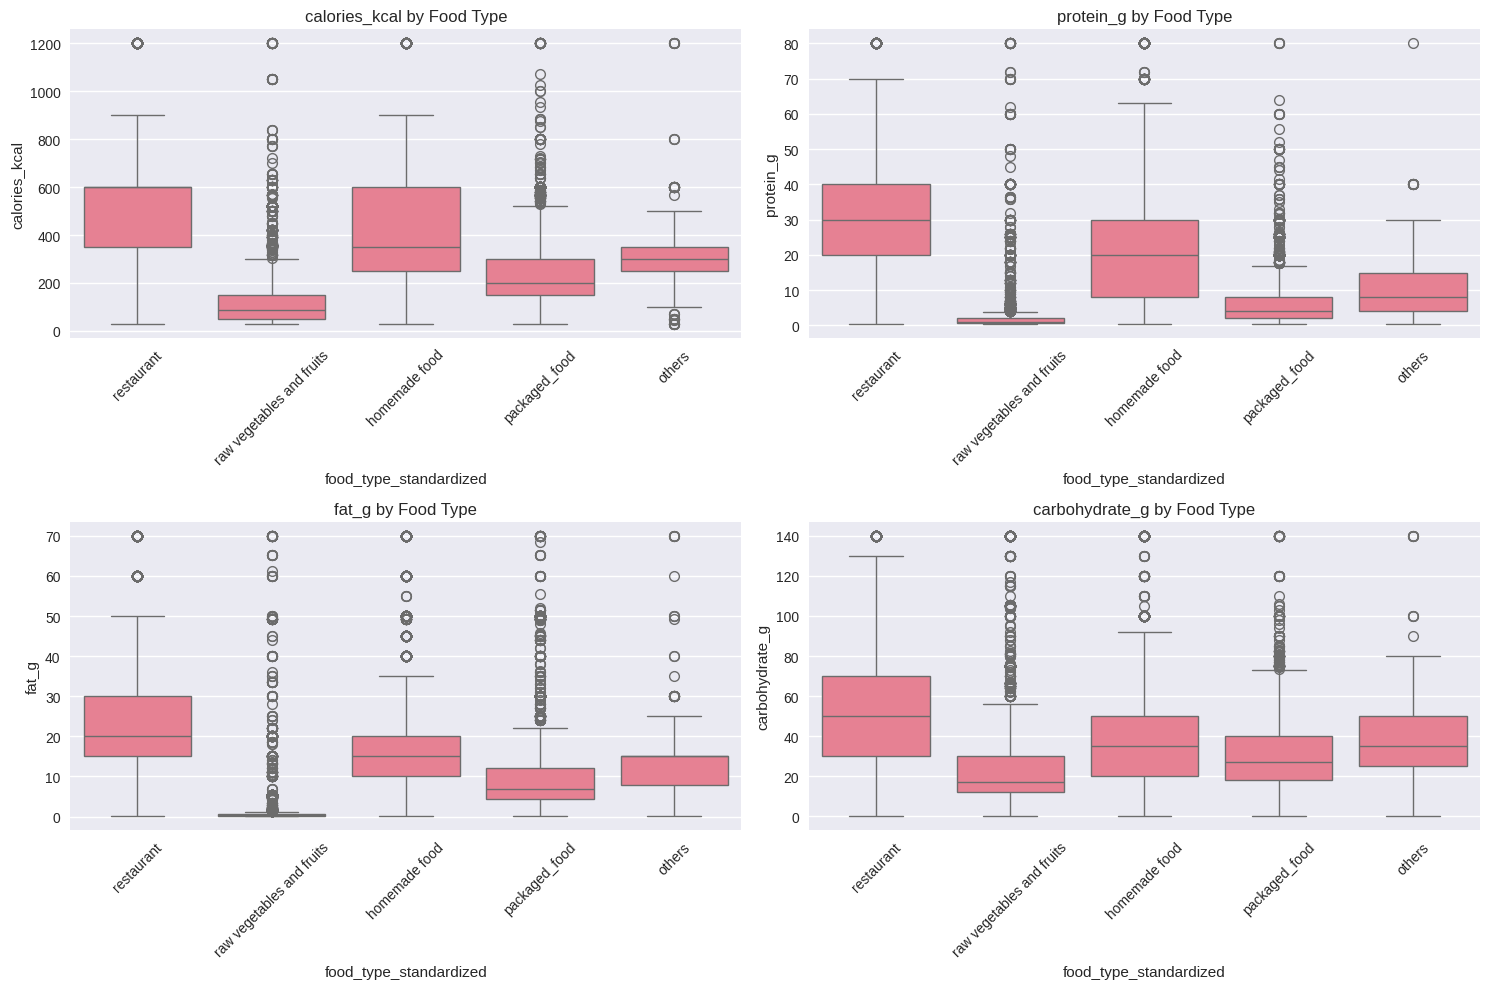


4. INGREDIENT ANALYSIS
Total unique ingredients: 3499
Total ingredient instances: 353774

Top 20 ingredients:
  vegetables: 15138
  spices: 12275
  sauce: 11828
  noodles: 11619
  green onions: 11496
  chicken: 10569
  meat: 9573
  rice: 9306
  sugar: 8043
  beef: 7472
  soy sauce: 6929
  broth: 6666
  eg: 5874
  shrimp: 5690
  garlic: 5639
  oi: 5491
  flour: 5302
  pork: 4561
  carrots: 4288
  seasonin: 4094


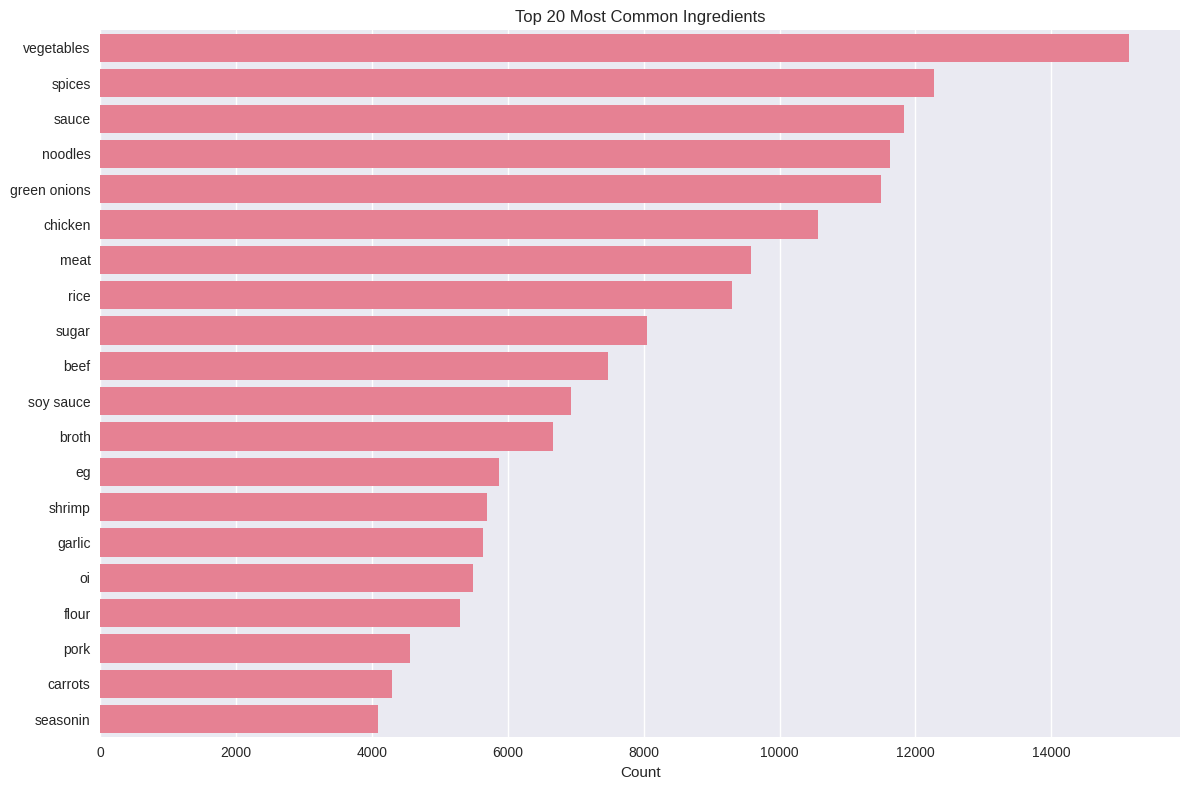


5. COOKING METHODS ANALYSIS
Total unique cooking methods: 1682
Total method instances: 100140

Top 15 cooking methods:
  raw: 11789
  stir-frying: 11217
  boiling: 7326
  fried: 6561
  baked: 4465
  boiled: 4298
  grilling: 4208
  stir-fried: 3525
  baking: 3280
  stewing: 1930
  steamed: 1914
  steaming: 1730
  braising: 1710
  boiled and stir-fried: 1673
  grilled: 1666


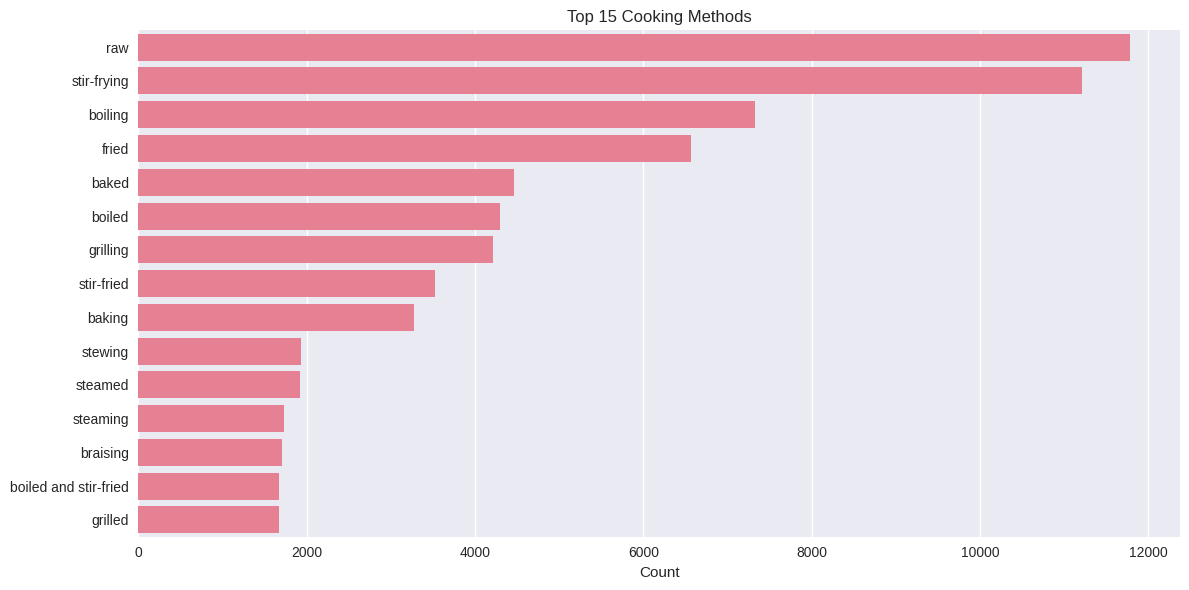


6. NUTRITIONAL ANALYSIS


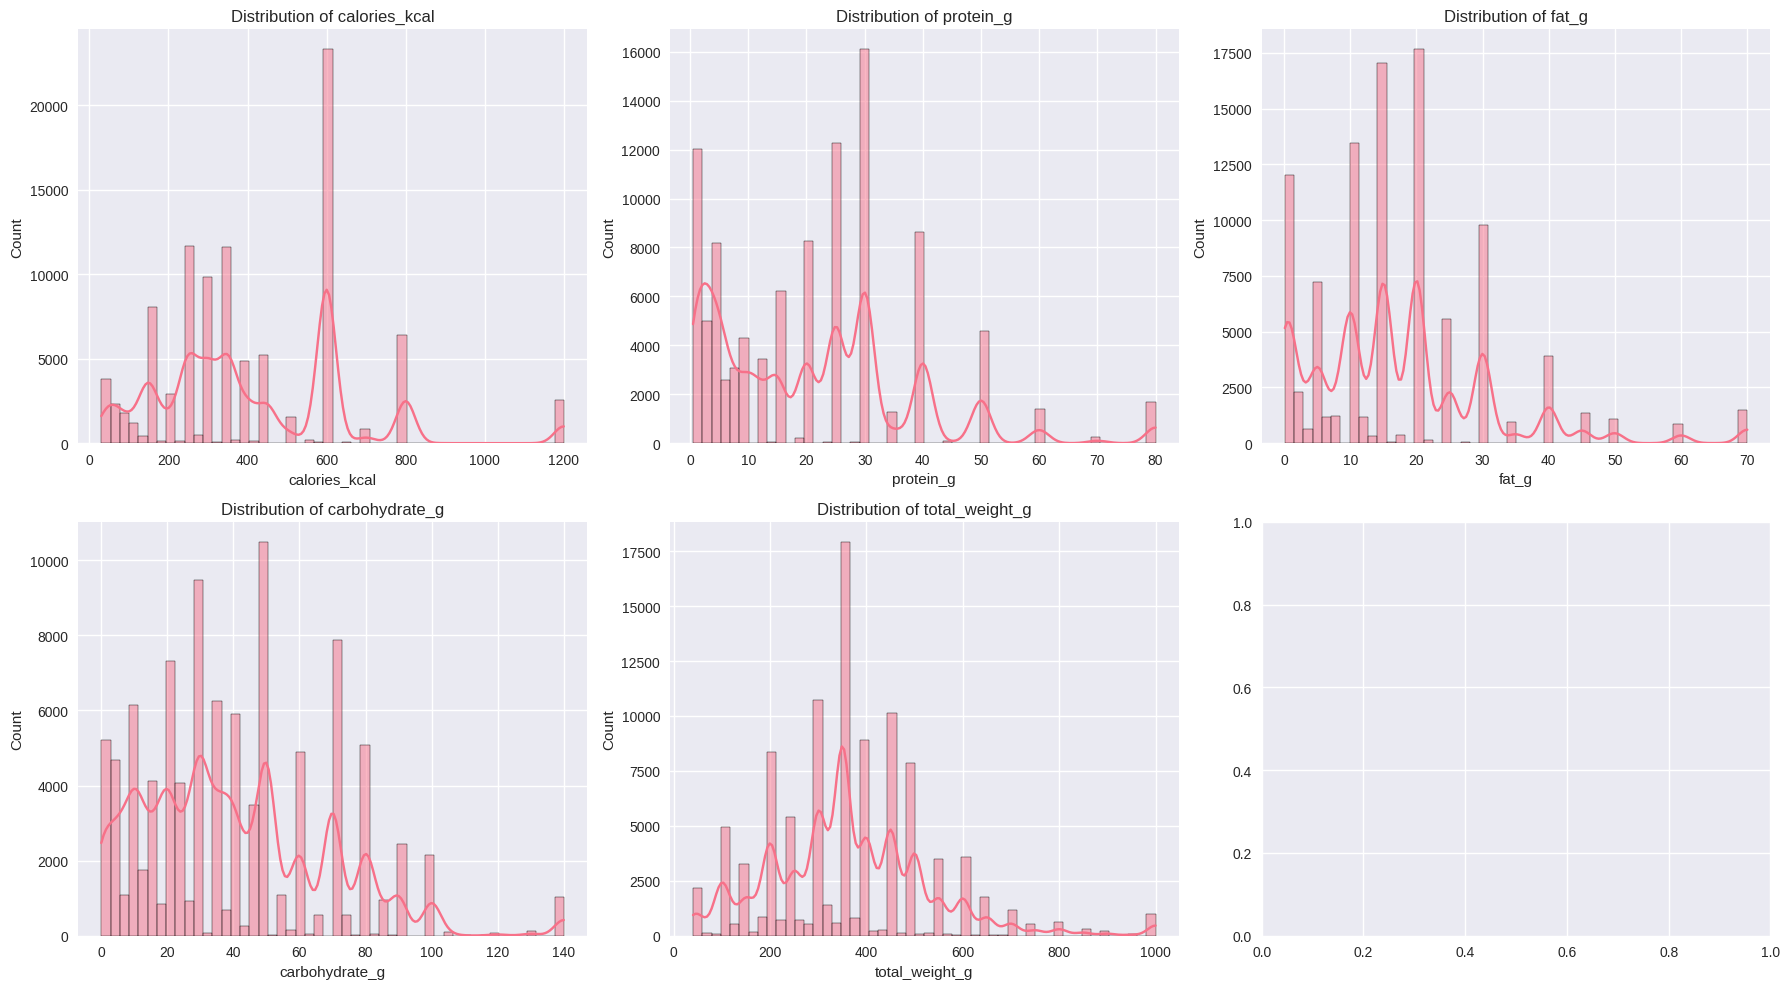

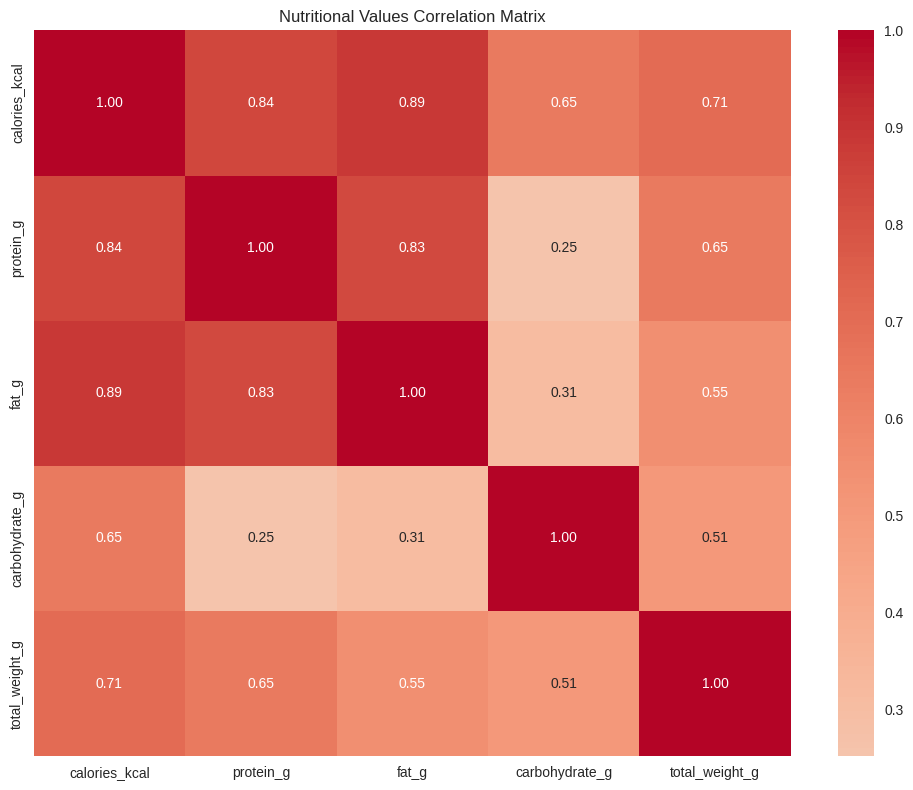


7. PORTION SIZE ANALYSIS
Average portion size: 363.05g
Median portion size: 350.00g
Portion size range: 40.00g - 1000.00g


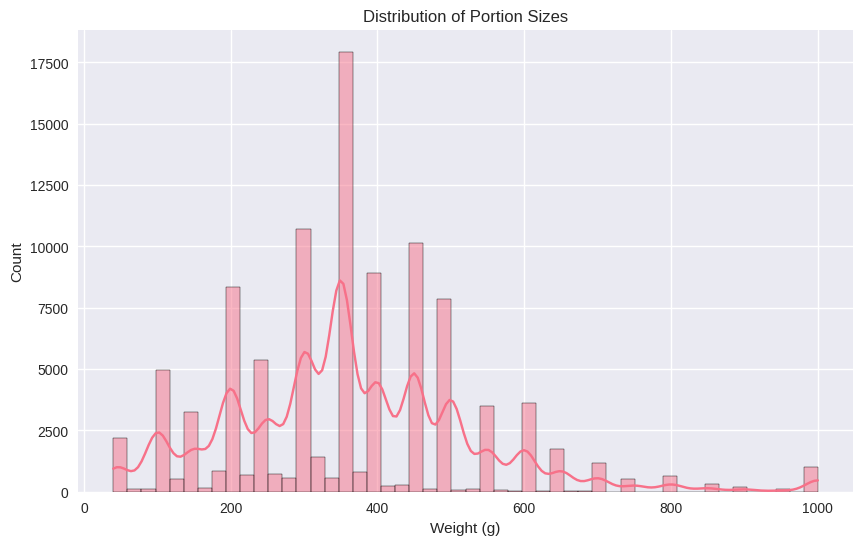


8. INGREDIENTS vs NUTRITION RELATIONSHIP


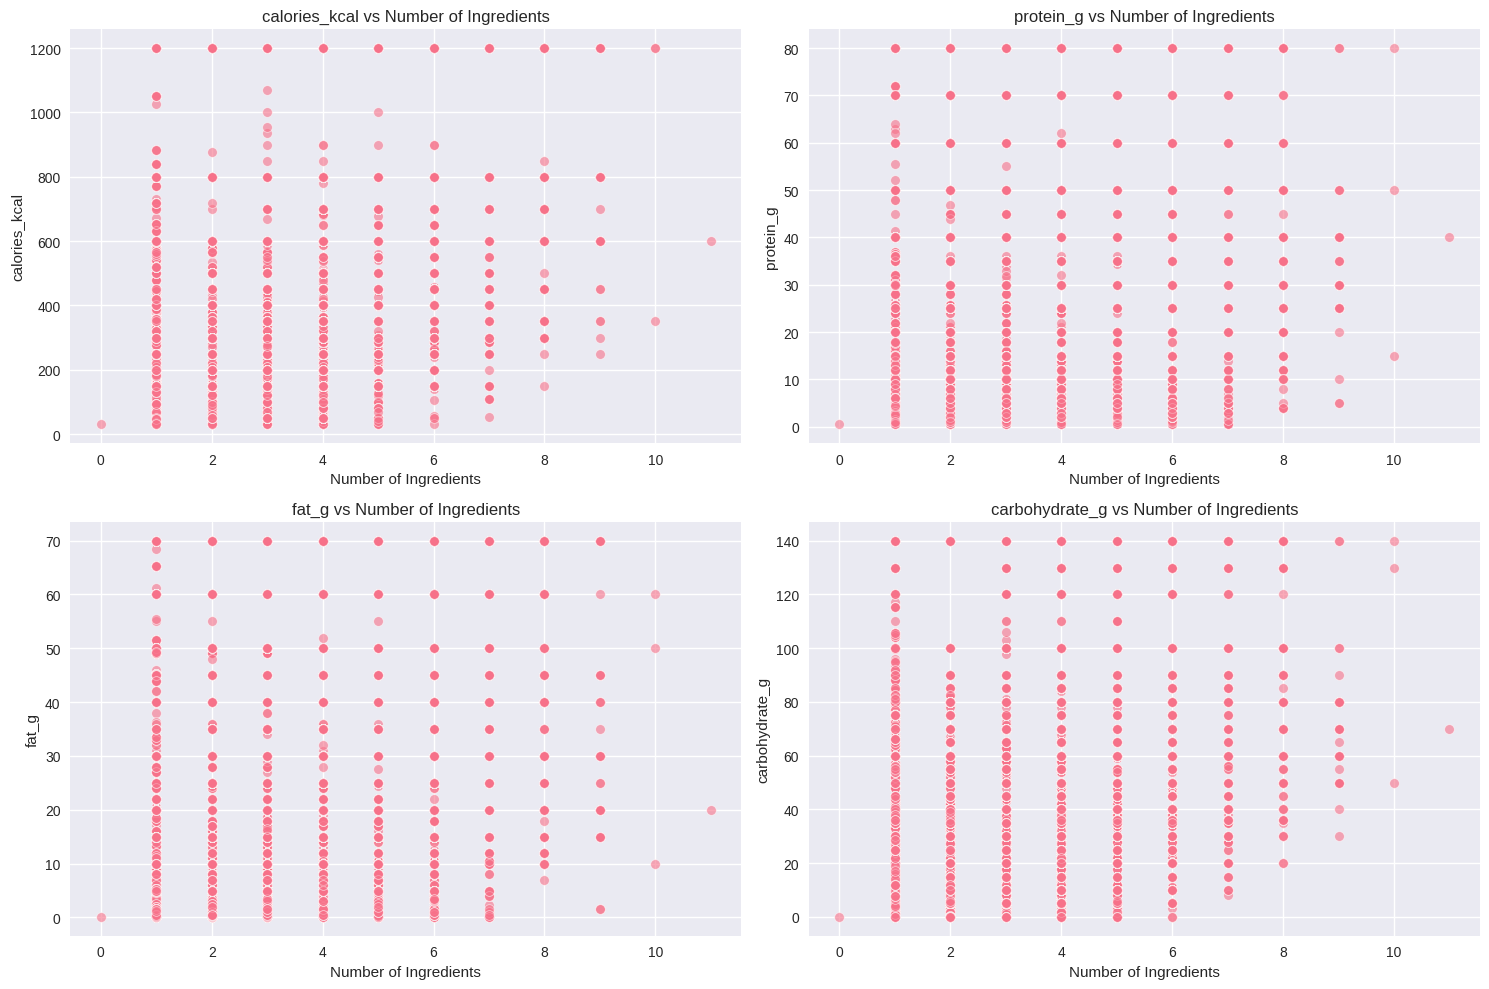

Correlation between ingredient count and nutrition:
calories_kcal     0.509
protein_g         0.398
fat_g             0.400
carbohydrate_g    0.411
total_weight_g    0.373
Name: num_ingredients, dtype: float64

9. COOKING METHODS vs NUTRITION RELATIONSHIP


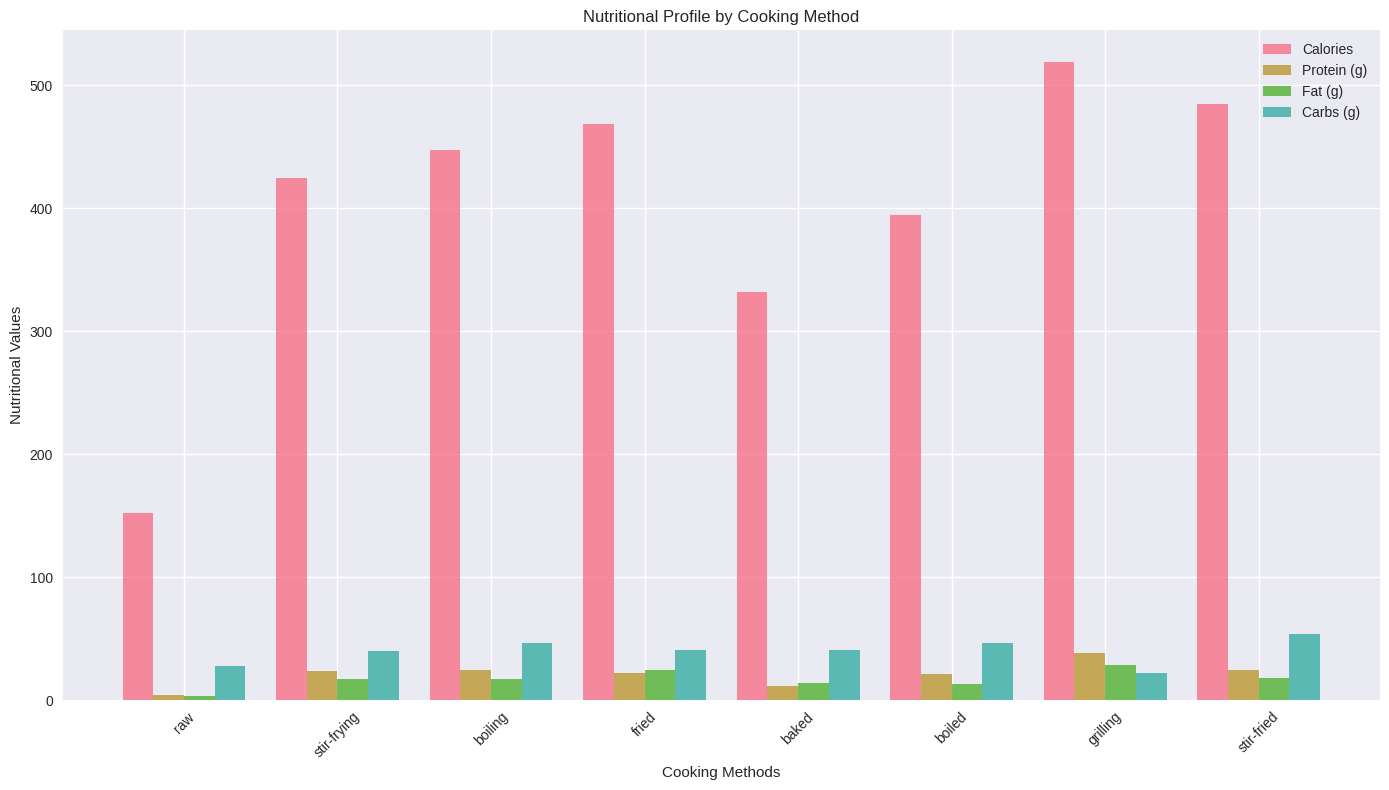


10. ADVANCED NUTRITIONAL ANALYSIS


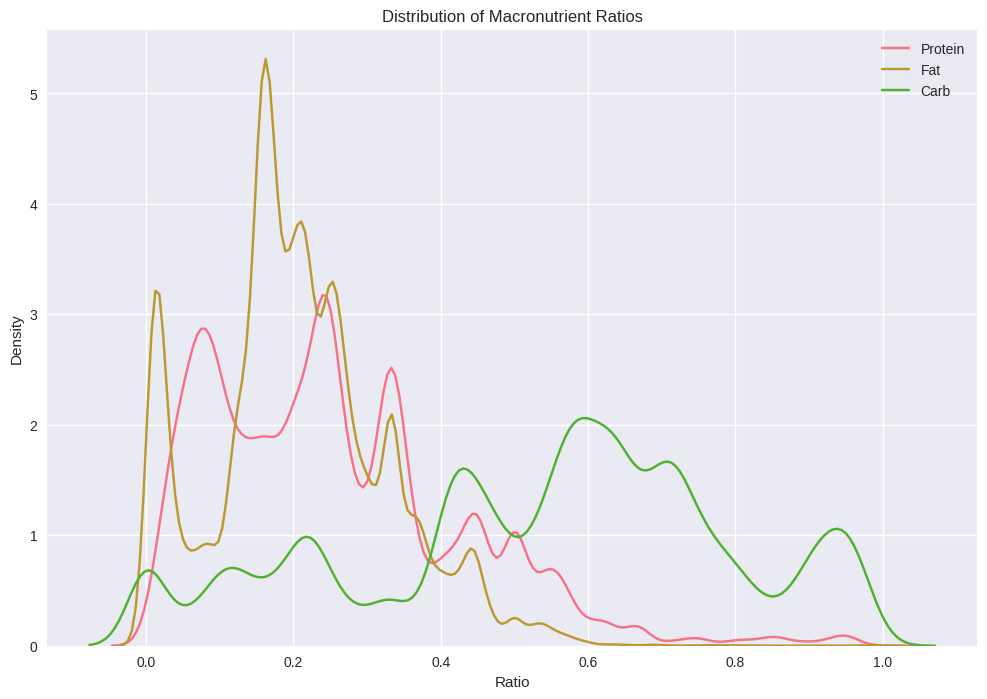

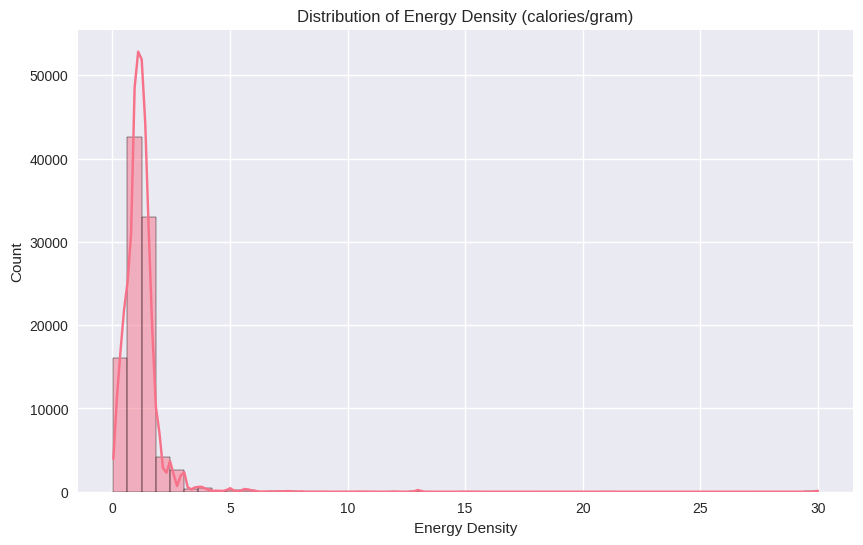


11. DATA QUALITY ASSESSMENT
Average data quality score: 0.997
Data quality distribution:
data_quality_score
0.50        1
0.75     1357
1.00    98642
Name: count, dtype: int64


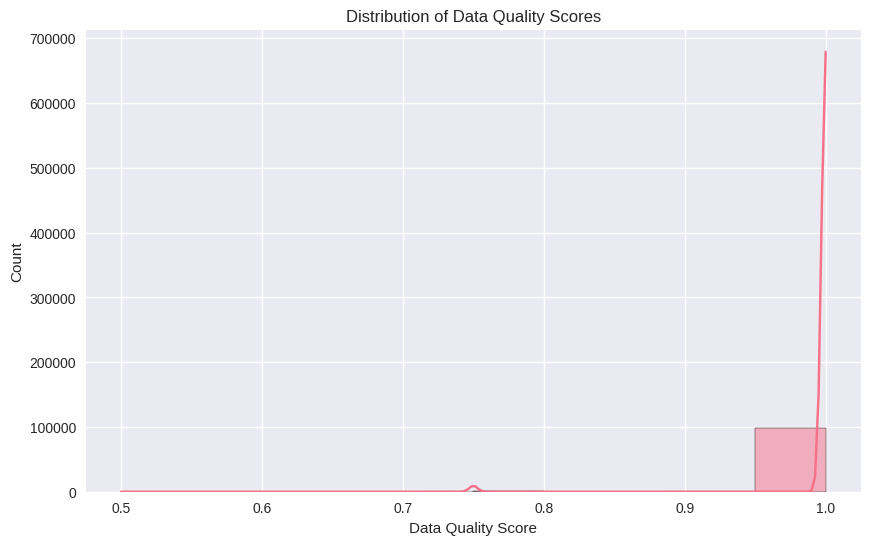


12. OUTLIER ANALYSIS
Outlier analysis:
  calories_kcal: 2569 outliers (2.57%)
  protein_g: 1697 outliers (1.70%)
  fat_g: 2344 outliers (2.34%)
  carbohydrate_g: 1164 outliers (1.16%)
  total_weight_g: 1306 outliers (1.31%)

13. TEMPORAL PATTERNS

'estimated_prep_time' column not found for temporal analysis.

14. COMPREHENSIVE SUMMARY
Dataset Summary:
  Total Recipes: 100000
  Avg Ingredients: 3.54
  Avg Cooking Methods: 1.00
  Avg Calories: 408.59
  Avg Protein: 21.15
  Avg Fat: 17.37
  Avg Carbs: 40.33
  Data Quality: 1.00


In [4]:
def comprehensive_eda_cleaned(df):
    """
    Comprehensive EDA using the cleaned dataset
    """
    print("="*60)
    print("COMPREHENSIVE EDA WITH CLEANED DATA")
    print("="*60)

    # 1. Dataset Overview
    print("1. DATASET OVERVIEW")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Data types:\n{df.dtypes.value_counts()}")

    # Check for remaining missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    print(f"\nMissing values:\n{missing_values[missing_values > 0]}")
    print(f"Missing percentage:\n{missing_percent[missing_percent > 0].round(2)}")

    # 2. Basic Statistics
    print("\n2. BASIC STATISTICS")

    # Nutritional statistics
    nutrition_cols = ['calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g', 'total_weight_g']
    print("Nutritional statistics:")
    print(df[nutrition_cols].describe().round(2))

    # Ingredient statistics
    df['num_ingredients'] = df['ingredients_cleaned'].apply(len)
    df['num_cooking_methods'] = df['cooking_methods_cleaned'].apply(len)

    print(f"\nAverage ingredients per recipe: {df['num_ingredients'].mean():.2f}")
    print(f"Average cooking methods per recipe: {df['num_cooking_methods'].mean():.2f}")
    # Removed the line referencing 'estimated_prep_time'
    # print(f"Average preparation time: {df['estimated_prep_time'].mean():.2f} minutes")

    # 3. Food Type Analysis
    print("\n3. FOOD TYPE ANALYSIS")

    if 'food_type_standardized' in df.columns:
        food_type_counts = df['food_type_standardized'].value_counts()
        print("Food type distribution:")
        for food_type, count in food_type_counts.items():
            print(f"  {food_type}: {count} ({count/len(df)*100:.1f}%)")

        # Nutritional comparison by food type
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        for i, col in enumerate(nutrition_cols[:4]):
            row, col_idx = i // 2, i % 2
            sns.boxplot(data=df, x='food_type_standardized', y=col, ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col} by Food Type')
            axes[row, col_idx].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

    # 4. Ingredient Analysis
    print("\n4. INGREDIENT ANALYSIS")

    # Get all ingredients
    all_ingredients = [ingredient for sublist in df['ingredients_cleaned'] for ingredient in sublist]
    ingredient_counts = Counter(all_ingredients)

    print(f"Total unique ingredients: {len(ingredient_counts)}")
    print(f"Total ingredient instances: {len(all_ingredients)}")

    # Top ingredients
    top_ingredients = ingredient_counts.most_common(20)
    print("\nTop 20 ingredients:")
    for ingredient, count in top_ingredients:
        print(f"  {ingredient}: {count}")

    # Plot top ingredients
    plt.figure(figsize=(12, 8))
    ingredients, counts = zip(*top_ingredients)
    sns.barplot(x=list(counts), y=list(ingredients))
    plt.title('Top 20 Most Common Ingredients')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

    # 5. Cooking Methods Analysis
    print("\n5. COOKING METHODS ANALYSIS")

    # Get all cooking methods
    all_methods = [method for sublist in df['cooking_methods_cleaned'] for method in sublist]
    method_counts = Counter(all_methods)

    print(f"Total unique cooking methods: {len(method_counts)}")
    print(f"Total method instances: {len(all_methods)}")

    # Top cooking methods
    top_methods = method_counts.most_common(15)
    print("\nTop 15 cooking methods:")
    for method, count in top_methods:
        print(f"  {method}: {count}")

    # Plot cooking methods
    plt.figure(figsize=(12, 6))
    methods, counts = zip(*top_methods)
    sns.barplot(x=list(counts), y=list(methods))
    plt.title('Top 15 Cooking Methods')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

    # 6. Nutritional Analysis
    print("\n6. NUTRITIONAL ANALYSIS")

    # Distribution of nutritional values
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Check if 'nutritional_density' exists before adding to list
    nutrition_cols_extended = nutrition_cols.copy()
    if 'nutritional_density' in df.columns:
        nutrition_cols_extended.append('nutritional_density')

    for i, col in enumerate(nutrition_cols_extended):
        row, col_idx = i // 3, i % 3
        if col in df.columns:
            sns.histplot(df[col].dropna(), bins=50, ax=axes[row, col_idx], kde=True)
            axes[row, col_idx].set_title(f'Distribution of {col}')
            axes[row, col_idx].set_xlabel(col)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    # Ensure all columns exist before calculating correlation
    cols_for_corr = [col for col in nutrition_cols_extended if col in df.columns]
    if len(cols_for_corr) > 1:
        nutritional_corr = df[cols_for_corr].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(nutritional_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Nutritional Values Correlation Matrix')
        plt.tight_layout()
        plt.show()
    else:
        print("\nInsufficient nutritional columns for correlation matrix.")


    # 7. Portion Size Analysis
    print("\n7. PORTION SIZE ANALYSIS")

    if 'total_weight_g' in df.columns:
        print(f"Average portion size: {df['total_weight_g'].mean():.2f}g")
        print(f"Median portion size: {df['total_weight_g'].median():.2f}g")
        print(f"Portion size range: {df['total_weight_g'].min():.2f}g - {df['total_weight_g'].max():.2f}g")

        plt.figure(figsize=(10, 6))
        sns.histplot(df['total_weight_g'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Portion Sizes')
        plt.xlabel('Weight (g)')
        plt.ylabel('Count')
        plt.show()

    # 8. Relationship: Ingredients vs Nutrition
    print("\n8. INGREDIENTS vs NUTRITION RELATIONSHIP")

    # Scatter plots: Number of ingredients vs nutritional values
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for i, col in enumerate(nutrition_cols[:4]):
        row, col_idx = i // 2, i % 2
        sns.scatterplot(data=df, x='num_ingredients', y=col, alpha=0.6, ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'{col} vs Number of Ingredients')
        axes[row, col_idx].set_xlabel('Number of Ingredients')
        axes[row, col_idx].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    # Correlation analysis
    ingredient_nutrition_corr = df[['num_ingredients'] + nutrition_cols].corr()
    print("Correlation between ingredient count and nutrition:")
    print(ingredient_nutrition_corr['num_ingredients'][1:].round(3))

    # 9. Relationship: Cooking Methods vs Nutrition
    print("\n9. COOKING METHODS vs NUTRITION RELATIONSHIP")

    # Analyze nutritional impact of cooking methods
    top_methods_list = [method for method, count in top_methods[:8]]
    method_nutrition = {}

    for method in top_methods_list:
        method_recipes = df[df['cooking_methods_cleaned'].apply(lambda x: method in x)]
        if len(method_recipes) > 10:
            method_nutrition[method] = {
                'count': len(method_recipes),
                'avg_calories': method_recipes['calories_kcal'].mean(),
                'avg_protein': method_recipes['protein_g'].mean(),
                'avg_fat': method_recipes['fat_g'].mean(),
                'avg_carbs': method_recipes['carbohydrate_g'].mean()
            }

    # Create comparison plot
    methods = list(method_nutrition.keys())
    calories = [method_nutrition[m]['avg_calories'] for m in methods]
    protein = [method_nutrition[m]['avg_protein'] for m in methods]
    fat = [method_nutrition[m]['avg_fat'] for m in methods]
    carbs = [method_nutrition[m]['avg_carbs'] for m in methods]

    x = np.arange(len(methods))
    width = 0.2

    plt.figure(figsize=(14, 8))
    plt.bar(x - width*1.5, calories, width, label='Calories', alpha=0.8)
    plt.bar(x - width/2, protein, width, label='Protein (g)', alpha=0.8)
    plt.bar(x + width/2, fat, width, label='Fat (g)', alpha=0.8)
    plt.bar(x + width*1.5, carbs, width, label='Carbs (g)', alpha=0.8)

    plt.xlabel('Cooking Methods')
    plt.ylabel('Nutritional Values')
    plt.title('Nutritional Profile by Cooking Method')
    plt.xticks(x, methods, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 10. Advanced Nutritional Analysis
    print("\n10. ADVANCED NUTRITIONAL ANALYSIS")

    # Macronutrient ratios
    # Check if columns exist before calculating ratios
    if all(col in df.columns for col in nutrition_cols):
        total_macros = df['protein_g'] + df['fat_g'] + df['carbohydrate_g']
        df['protein_ratio'] = df['protein_g'] / total_macros.replace(0, 1)
        df['fat_ratio'] = df['fat_g'] / total_macros.replace(0, 1)
        df['carb_ratio'] = df['carbohydrate_g'] / total_macros.replace(0, 1)

        # Plot macronutrient distribution
        macro_ratios = ['protein_ratio', 'fat_ratio', 'carb_ratio']
        plt.figure(figsize=(12, 8))
        for ratio in macro_ratios:
            sns.kdeplot(df[ratio].dropna(), label=ratio.replace('_ratio', '').title())
        plt.title('Distribution of Macronutrient Ratios')
        plt.xlabel('Ratio')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    else:
        print("\nInsufficient nutritional columns for macronutrient ratio analysis.")


    # Energy density analysis
    if 'total_weight_g' in df.columns and 'calories_kcal' in df.columns:
        df['energy_density'] = df['calories_kcal'] / df['total_weight_g'].replace(0, 1)

        plt.figure(figsize=(10, 6))
        sns.histplot(df['energy_density'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Energy Density (calories/gram)')
        plt.xlabel('Energy Density')
        plt.ylabel('Count')
        plt.show()
    else:
        print("\nInsufficient columns for energy density analysis.")


    # 11. Data Quality Assessment
    print("\n11. DATA QUALITY ASSESSMENT")

    if 'data_quality_score' in df.columns:
        print(f"Average data quality score: {df['data_quality_score'].mean():.3f}")
        print(f"Data quality distribution:")
        print(df['data_quality_score'].value_counts().sort_index())

        plt.figure(figsize=(10, 6))
        sns.histplot(df['data_quality_score'], bins=10, kde=True)
        plt.title('Distribution of Data Quality Scores')
        plt.xlabel('Data Quality Score')
        plt.ylabel('Count')
        plt.show()
    else:
        print("\n'data_quality_score' column not found for quality assessment.")


    # 12. Outlier Analysis
    print("\n12. OUTLIER ANALYSIS")

    def detect_outliers(series, threshold=3):
        z_scores = np.abs((series - series.mean()) / series.std())
        return z_scores > threshold

    outlier_cols = ['calories_kcal', 'protein_g', 'fat_g', 'carbohydrate_g', 'total_weight_g']
    outlier_results = {}

    for col in outlier_cols:
        if col in df.columns:
            outliers = detect_outliers(df[col].dropna())
            outlier_results[col] = {
                'count': outliers.sum(),
                'percentage': (outliers.sum() / len(df[col].dropna())) * 100
            }
        else:
            outlier_results[col] = {'count': 0, 'percentage': 0.0}


    print("Outlier analysis:")
    for col, results in outlier_results.items():
        print(f"  {col}: {results['count']} outliers ({results['percentage']:.2f}%)")

    # 13. Temporal Patterns (Preparation Time)
    print("\n13. TEMPORAL PATTERNS")

    if 'estimated_prep_time' in df.columns:
        print(f"Preparation time statistics:")
        print(f"  Mean: {df['estimated_prep_time'].mean():.2f} minutes")
        print(f"  Median: {df['estimated_prep_time'].median():.2f} minutes")
        print(f"  Std: {df['estimated_prep_time'].std():.2f} minutes")

        # Preparation time distribution
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df['estimated_prep_time'].dropna(), bins=30, kde=True)
        plt.title('Distribution of Preparation Time')
        plt.xlabel('Minutes')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df['estimated_prep_time'].dropna())
        plt.title('Boxplot of Preparation Time')
        plt.ylabel('Minutes')

        plt.tight_layout()
        plt.show()

        # Preparation time vs complexity
        if 'num_ingredients' in df.columns and 'num_cooking_methods' in df.columns:
            complexity_corr = df[['estimated_prep_time', 'num_ingredients', 'num_cooking_methods']].corr()
            print("Correlation between preparation time and complexity:")
            print(complexity_corr['estimated_prep_time'][1:].round(3))
        else:
             print("\nInsufficient columns for preparation time vs complexity analysis.")
    else:
        print("\n'estimated_prep_time' column not found for temporal analysis.")


    # 14. Comprehensive Summary
    print("\n14. COMPREHENSIVE SUMMARY")

    summary_stats = {
        'total_recipes': len(df),
        'avg_ingredients': df['num_ingredients'].mean(),
        'avg_cooking_methods': df['num_cooking_methods'].mean(),
        'avg_calories': df['calories_kcal'].mean(),
        'avg_protein': df['protein_g'].mean(),
        'avg_fat': df['fat_g'].mean(),
        'avg_carbs': df['carbohydrate_g'].mean(),
        'avg_prep_time': df['estimated_prep_time'].mean() if 'estimated_prep_time' in df.columns else None,
        'data_quality': df['data_quality_score'].mean() if 'data_quality_score' in df.columns else None
    }

    print("Dataset Summary:")
    for key, value in summary_stats.items():
        if value is not None:
            if isinstance(value, float):
                print(f"  {key.replace('_', ' ').title()}: {value:.2f}")
            else:
                print(f"  {key.replace('_', ' ').title()}: {value}")

    return {
        'ingredient_counts': ingredient_counts,
        'method_counts': method_counts,
        'nutritional_stats': df[nutrition_cols].describe(),
        'outlier_analysis': outlier_results,
        'summary_stats': summary_stats
    }

# Run comprehensive EDA on cleaned data
eda_results = comprehensive_eda_cleaned(df)

## 3 - Feature Engineering

### 3.1 Multimodal Feature Extraction

Extracts multimodal features including:

*    Nutritional ratios and distributions

*    Ingredient co-occurrence networks

*    Cultural cuisine clustering

*   Portion size analysis

*    Image quality assessment (placeholder)

In [5]:
def multimodal_feature_extraction(df):
    """Extract multimodal features from the dataset"""
    print("="*50)
    print("MULTIMODAL FEATURE EXTRACTION")
    print("="*50)

    # 1. Nutritional Analysis Features
    print("\n1. Nutritional Analysis Features")

    # Calculate nutritional ratios
    df['protein_calorie_ratio'] = df['protein_g'] / df['calories_kcal']
    df['fat_calorie_ratio'] = df['fat_g'] / df['calories_kcal']
    df['carb_calorie_ratio'] = df['carbohydrate_g'] / df['calories_kcal']

    # Replace infinities with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 2. Ingredient Network Analysis
    print("\n2. Ingredient Network Analysis")

    # Create ingredient co-occurrence matrix
    all_ingredients = list(set([ingredient for sublist in df['ingredients_cleaned'].tolist() for ingredient in sublist]))
    ingredient_index = {ingredient: idx for idx, ingredient in enumerate(all_ingredients)}

    # Initialize co-occurrence matrix
    co_occurrence = np.zeros((len(all_ingredients), len(all_ingredients)))

    # Fill co-occurrence matrix
    for ingredients in df['ingredients_cleaned']:
        for i in range(len(ingredients)):
            for j in range(i+1, len(ingredients)):
                idx1 = ingredient_index[ingredients[i]]
                idx2 = ingredient_index[ingredients[j]]
                co_occurrence[idx1, idx2] += 1
                co_occurrence[idx2, idx1] += 1

    # Create ingredient graph
    G = nx.Graph()

    # Add nodes
    for ingredient in all_ingredients:
        G.add_node(ingredient)

    # Add edges (only for top ingredients to reduce complexity)
    top_ingredients = [ingredient for ingredient, count in Counter(all_ingredients).most_common(50)]

    for i in range(len(top_ingredients)):
        for j in range(i+1, len(top_ingredients)):
            ing1, ing2 = top_ingredients[i], top_ingredients[j]
            idx1, idx2 = ingredient_index[ing1], ingredient_index[ing2]
            weight = co_occurrence[idx1, idx2]
            if weight > 0:
                G.add_edge(ing1, ing2, weight=weight)

    # Calculate network metrics
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    print(f"Ingredient network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print("Top ingredients by degree centrality:")
    for ingredient in sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]:
        print(f"{ingredient}: {degree_centrality[ingredient]:.4f}")

    # 3. Cultural Cuisine Clustering
    print("\n3. Cultural Cuisine Clustering")

    # Create features for clustering (simplified approach)
    # In a real scenario, we'd use more sophisticated text embeddings
    cuisine_keywords = {
        'italian': ['pasta', 'tomato', 'basil', 'olive oil', 'parmesan'],
        'mexican': ['tortilla', 'chili', 'avocado', 'lime', 'cilantro'],
        'asian': ['soy sauce', 'ginger', 'garlic', 'rice', 'sesame oil'],
        'indian': ['curry', 'turmeric', 'cumin', 'coriander', 'garam masala'],
        'american': ['cheese', 'beef', 'potato', 'ketchup', 'mayonnaise']
    }

    def detect_cuisine(ingredients):
        scores = {cuisine: 0 for cuisine in cuisine_keywords}
        for ingredient in ingredients:
            for cuisine, keywords in cuisine_keywords.items():
                if ingredient in keywords:
                    scores[cuisine] += 1
        if max(scores.values()) == 0:
            return 'unknown'
        return max(scores.items(), key=lambda x: x[1])[0]

    df['predicted_cuisine'] = df['ingredients_cleaned'].apply(detect_cuisine)

    print("Cuisine distribution:")
    print(df['predicted_cuisine'].value_counts())

    # 4. Portion Size Analysis
    print("\n4. Portion Size Analysis")

    # Calculate realistic serving sizes based on food type
    serving_sizes = df.groupby('food_type_standardized')['total_weight_g'].agg(['mean', 'median', 'std']).round(2)
    print("Serving sizes by food type:")
    print(serving_sizes)

    # Flag unrealistic portion sizes (outside 2 standard deviations)
    def flag_unrealistic_portion(row):
        if pd.isna(row['total_weight_g']):
            return False
        food_type = row['food_type_standardized']
        # Check if food_type exists in serving_sizes index
        if food_type not in serving_sizes.index:
            return False # Or handle as appropriate

        stats = serving_sizes.loc[food_type]
        # Handle potential NaN or Inf in stats
        if pd.isna(stats['mean']) or pd.isna(stats['std']):
            return False

        lower_bound = stats['mean'] - 2 * stats['std']
        upper_bound = stats['mean'] + 2 * stats['std']
        return row['total_weight_g'] < lower_bound or row['total_weight_g'] > upper_bound

    df['unrealistic_portion'] = df.apply(flag_unrealistic_portion, axis=1)
    print(f"Number of unrealistic portion sizes: {df['unrealistic_portion'].sum()}")

    # 5. Image Quality Assessment (simulated - would need actual images)
    print("\n5. Image Quality Assessment")

    # This would normally require downloading and processing images
    # For demonstration, we'll create placeholder features
    df['image_quality_score'] = np.random.uniform(0.7, 1.0, len(df))  # Placeholder

    print("Image quality score distribution:")
    print(df['image_quality_score'].describe())

    return df, G

# Extract multimodal features
df, ingredient_graph = multimodal_feature_extraction(df)

MULTIMODAL FEATURE EXTRACTION

1. Nutritional Analysis Features

2. Ingredient Network Analysis
Ingredient network created with 3499 nodes and 12 edges
Top ingredients by degree centrality:
carrots: 0.0017
cream: 0.0014
lobster: 0.0009
toast: 0.0009
dried chili peppers: 0.0003
brussels sprouts: 0.0003
pickled radish: 0.0003
sandwich: 0.0003
beet: 0.0003
flan: 0.0003

3. Cultural Cuisine Clustering
Cuisine distribution:
predicted_cuisine
unknown     65263
asian       18188
american     8244
mexican      4902
italian      3189
indian        214
Name: count, dtype: int64

4. Portion Size Analysis
Serving sizes by food type:
                             mean  median     std
food_type_standardized                           
homemade food              366.74   350.0  138.12
others                     261.63   250.0  152.25
packaged_food              173.39   100.0  134.57
raw vegetables and fruits  283.57   200.0  205.83
restaurant                 424.64   400.0  154.43
Number of unrealistic

### 3.2 Nutritional Engineering

Engineers advanced nutritional features including:

*    Macronutrient ratios

*     Health indicators (high-fiber, low-sodium, balanced meal flags)

*     Dietary compatibility (vegan, keto, paleo, gluten-free)

*     Nutritional density scores

NUTRITIONAL ENGINEERING

1. Macronutrient Ratios

2. Health Indicators
High fiber meals: 4048
Low sodium meals: 29887
Balanced meals: 18969

3. Dietary Compatibility
Dietary compatibility counts:
Vegan: 59013
Keto: 76926
Paleo: 99821
Gluten-free: 96841

4. Nutritional Density Scores
Nutritional density score distribution:
count    100000.000000
mean          4.970552
std           2.755409
min          -0.958333
25%           2.333333
50%           5.000000
75%           7.384615
max          10.571429
Name: nutritional_density, dtype: float64


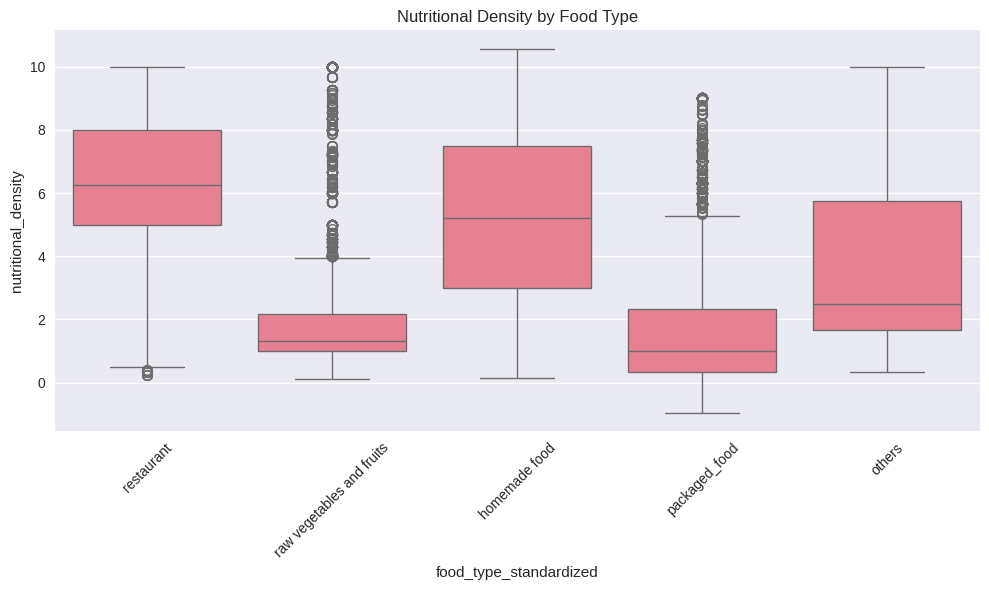

In [6]:
def nutritional_engineering(df):
    """Create advanced nutritional features"""
    print("="*50)
    print("NUTRITIONAL ENGINEERING")
    print("="*50)

    # 1. Macronutrient Ratios
    print("\n1. Macronutrient Ratios")

    # Calculate macronutrient percentages
    total_macros = df['protein_g'] + df['fat_g'] + df['carbohydrate_g']
    df['protein_pct'] = df['protein_g'] / total_macros * 100
    df['fat_pct'] = df['fat_g'] / total_macros * 100
    df['carb_pct'] = df['carbohydrate_g'] / total_macros * 100

    # Replace infinities with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 2. Health Indicators
    print("\n2. Health Indicators")

    # High fiber flag (assuming we had fiber data)
    # For demonstration, we'll create a placeholder based on ingredients
    high_fiber_ingredients = ['whole wheat', 'oats', 'beans', 'lentils', 'broccoli',
                             'avocado', 'berries', 'apples', 'nuts', 'seeds']

    def has_high_fiber(ingredients):
        return any(ingredient in high_fiber_ingredients for ingredient in ingredients)

    df['high_fiber'] = df['ingredients_cleaned'].apply(has_high_fiber)

    # Low sodium flag (placeholder)
    df['low_sodium'] = np.random.choice([True, False], len(df), p=[0.3, 0.7])

    # Balanced meal flag (reasonable distribution of macros)
    def is_balanced(row):
        if pd.isna(row['protein_pct']) or pd.isna(row['fat_pct']) or pd.isna(row['carb_pct']):
            return False
        return (15 <= row['protein_pct'] <= 35 and
                20 <= row['fat_pct'] <= 40 and
                35 <= row['carb_pct'] <= 65)

    df['balanced_meal'] = df.apply(is_balanced, axis=1)

    print(f"High fiber meals: {df['high_fiber'].sum()}")
    print(f"Low sodium meals: {df['low_sodium'].sum()}")
    print(f"Balanced meals: {df['balanced_meal'].sum()}")

    # 3. Dietary Compatibility
    print("\n3. Dietary Compatibility")

    # Define dietary restrictions
    vegan_restricted = ['meat', 'chicken', 'beef', 'pork', 'fish', 'seafood', 'egg',
                       'dairy', 'milk', 'cheese', 'butter', 'honey', 'gelatin']
    keto_restricted = ['sugar', 'honey', 'maple syrup', 'rice', 'pasta', 'bread', 'potato',
                      'corn', 'beans', 'grains', 'fruit juice']
    paleo_restricted = ['dairy', 'legumes', 'grains', 'processed food', 'refined sugar',
                       'vegetable oil', 'soy', 'peanut']
    gluten_restricted = ['wheat', 'barley', 'rye', 'bread', 'pasta', 'cereal', 'couscous']

    def check_diet_compatibility(ingredients, diet_restrictions):
        return not any(ingredient in diet_restrictions for ingredient in ingredients)

    df['vegan'] = df['ingredients_cleaned'].apply(lambda x: check_diet_compatibility(x, vegan_restricted))
    df['keto'] = df['ingredients_cleaned'].apply(lambda x: check_diet_compatibility(x, keto_restricted))
    df['paleo'] = df['ingredients_cleaned'].apply(lambda x: check_diet_compatibility(x, paleo_restricted))
    df['gluten_free'] = df['ingredients_cleaned'].apply(lambda x: check_diet_compatibility(x, gluten_restricted))

    print("Dietary compatibility counts:")
    print(f"Vegan: {df['vegan'].sum()}")
    print(f"Keto: {df['keto'].sum()}")
    print(f"Paleo: {df['paleo'].sum()}")
    print(f"Gluten-free: {df['gluten_free'].sum()}")

    # 4. Nutritional Density Scores
    print("\n4. Nutritional Density Scores")

    # Create a simplified nutritional density score
    # In a real scenario, this would incorporate more nutrients
    def calculate_nutritional_density(row):
        if pd.isna(row['calories_kcal']) or row['calories_kcal'] == 0:
            return np.nan

        # Base score on protein content (higher protein = more nutrient dense)
        protein_score = min(row['protein_g'] / row['calories_kcal'] * 100, 10)

        # Adjust based on food type
        food_type_bonus = {
            'raw_vegetables_fruits': 2,
            'homemade': 1,
            'restaurant': 0,
            'packaged_food': -1
        }.get(row['food_type_standardized'], 0)

        # Adjust based on balanced meal flag
        balance_bonus = 2 if row['balanced_meal'] else 0

        return protein_score + food_type_bonus + balance_bonus

    df['nutritional_density'] = df.apply(calculate_nutritional_density, axis=1)

    print("Nutritional density score distribution:")
    print(df['nutritional_density'].describe())

    # Visualize nutritional density by food type
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='food_type_standardized', y='nutritional_density')
    plt.title('Nutritional Density by Food Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

# Perform nutritional engineering
df = nutritional_engineering(df)

## 4 - Machine Learning Models

In [7]:
# Add these imports at the top of Section 4 if they're missing:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import psutil

In [8]:
# Add memory check function
def check_memory():
    """Check memory usage and trigger garbage collection if needed"""
    memory = psutil.virtual_memory()
    if memory.percent > 80:
        print(f"Warning: Memory usage at {memory.percent}%")
        gc.collect()
    return memory.percent

Starting memory-efficient ML pipeline...
MEMORY-EFFICIENT MACHINE LEARNING PIPELINE
Starting memory usage: 20.1%
Using features: ['protein_g', 'fat_g', 'carbohydrate_g', 'total_weight_g', 'num_ingredients', 'num_cooking_methods', 'protein_ratio', 'fat_ratio', 'carb_ratio', 'energy_density', 'nutritional_density']
Final dataset shape: (100000, 11)

2. TRAINING LIGHTWEIGHT MODELS...
Training Random Forest...
  Random Forest - R²: 0.9972, MAE: 3.16, RMSE: 12.60
Training Linear Regression...
  Linear Regression - R²: 0.9837, MAE: 20.02, RMSE: 30.64
Training XGBoost...
  XGBoost - R²: 0.9982, MAE: 4.34, RMSE: 10.08

3. MODEL COMPARISON
Model Performance Comparison:
            Model  R² Score       MAE      RMSE
          XGBoost  0.998232  4.338977 10.078269
    Random Forest  0.997237  3.163775 12.598323
Linear Regression  0.983658 20.024237 30.641131


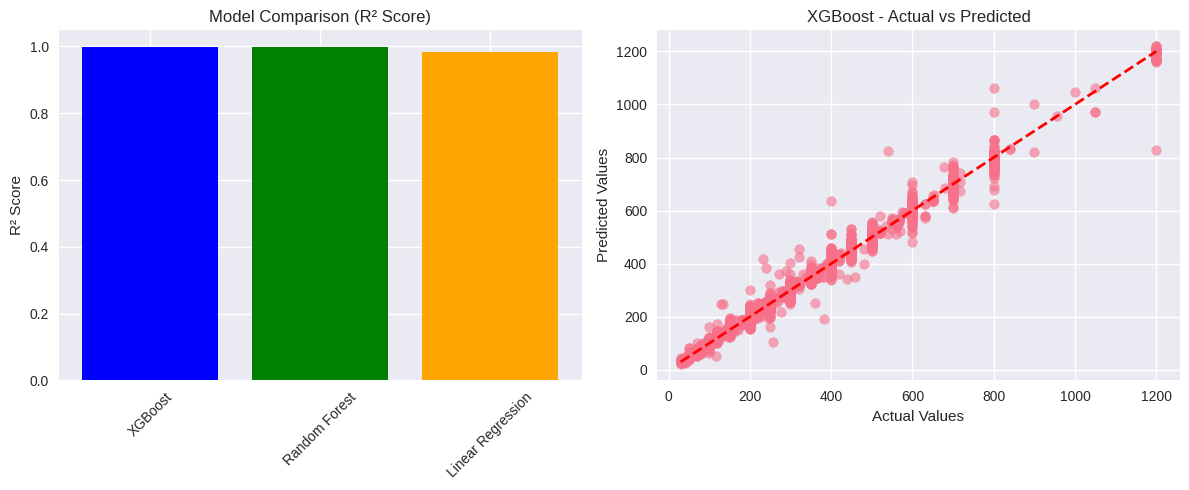

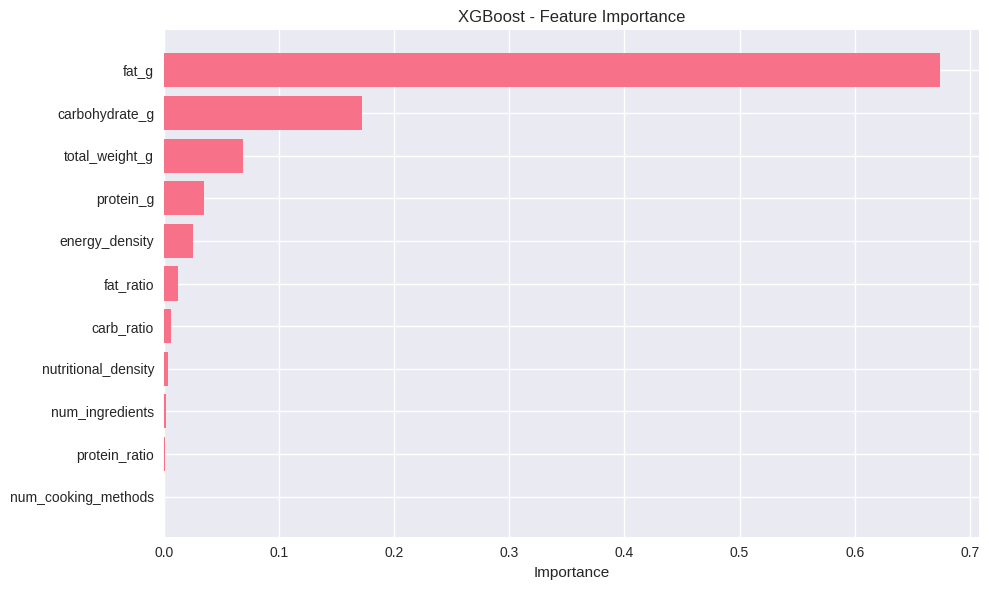


Best model: XGBoost (R²: 0.9982)
Final memory usage: 20.1%

ML Pipeline completed successfully!


In [9]:
def memory_efficient_ml_pipeline(df, target_variable='calories_kcal', test_size=0.2, random_state=42, max_samples=100000):
    """
    Memory-efficient ML pipeline that samples data to prevent crashes
    """
    print("="*60)
    print("MEMORY-EFFICIENT MACHINE LEARNING PIPELINE")
    print("="*60)

    # Check memory at start
    memory_usage = check_memory()
    print(f"Starting memory usage: {memory_usage:.1f}%")

    # 1. Sample data if too large
    if len(df) > max_samples:
        print(f"Sampling {max_samples} rows from {len(df)} total rows to prevent memory issues")
        df_sample = df.sample(n=max_samples, random_state=random_state)
    else:
        df_sample = df.copy()

    # 2. Select only essential features to reduce memory usage
    essential_features = [
        'protein_g', 'fat_g', 'carbohydrate_g', 'total_weight_g',
        'num_ingredients', 'num_cooking_methods'
    ]

    # Add optional features if they exist
    optional_features = [
        'protein_ratio', 'fat_ratio', 'carb_ratio', 'energy_density',
        'nutritional_density', 'cooking_health_score'
    ]

    # Filter to existing columns
    available_features = [col for col in essential_features if col in df_sample.columns]
    available_features.extend([col for col in optional_features if col in df_sample.columns])

    if len(available_features) < 3:
        print("ERROR: Insufficient features available for modeling")
        print(f"Available columns: {list(df_sample.columns)}")
        return None

    print(f"Using features: {available_features}")

    # 3. Handle missing values
    X = df_sample[available_features].copy()
    y = df_sample[target_variable].copy()

    # Check for missing target values
    missing_target = y.isna().sum()
    if missing_target > 0:
        print(f"Removing {missing_target} rows with missing target values")
        valid_indices = y.notna()
        X = X[valid_indices]
        y = y[valid_indices]

    if len(X) == 0:
        print("ERROR: No valid data remaining after cleaning")
        return None

    # Simple imputation for features
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=available_features)

    print(f"Final dataset shape: {X.shape}")

    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    check_memory()  # Check memory after preprocessing

    # 5. Use lightweight models to prevent crashes
    print("\n2. TRAINING LIGHTWEIGHT MODELS...")

    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=50,
            max_depth=10,
            random_state=random_state,
            n_jobs=1  # Limit parallel processing
        ),
        'Linear Regression': LinearRegression()
    }

    # Try to include XGBoost if available, but with limited resources
    try:
        from xgboost import XGBRegressor
        models['XGBoost'] = XGBRegressor(
            n_estimators=50,
            max_depth=6,
            random_state=random_state,
            n_jobs=1,
            verbosity=0
        )
    except ImportError:
        print("XGBoost not available, using Random Forest and Linear Regression only")

    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        try:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            results[name] = {
                'model': model,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'predictions': y_pred
            }

            print(f"  {name} - R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

        except Exception as e:
            print(f"  {name} failed: {str(e)}")
            continue

        check_memory()  # Check memory after each model

    if not results:
        print("ERROR: No models trained successfully")
        return None

    # 6. Model comparison
    print("\n3. MODEL COMPARISON")

    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'R² Score': result['r2'],
            'MAE': result['mae'],
            'RMSE': result['rmse']
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('R² Score', ascending=False)
    print("Model Performance Comparison:")
    print(comparison_df.to_string(index=False))

    # 7. Simple visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Model comparison
    model_names = comparison_df['Model']
    r2_scores = comparison_df['R² Score']

    axes[0].bar(model_names, r2_scores, color=['blue', 'green', 'orange'][:len(model_names)])
    axes[0].set_title('Model Comparison (R² Score)')
    axes[0].set_ylabel('R² Score')
    axes[0].tick_params(axis='x', rotation=45)

    # Best model predictions
    best_model_name = comparison_df.iloc[0]['Model']
    best_predictions = results[best_model_name]['predictions']

    axes[1].scatter(y_test, best_predictions, alpha=0.6)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].set_title(f'{best_model_name} - Actual vs Predicted')

    plt.tight_layout()
    plt.show()

    # 8. Feature importance for best model
    if hasattr(results[best_model_name]['model'], 'feature_importances_'):
        importance = results[best_model_name]['model'].feature_importances_
        feature_importance = pd.DataFrame({
            'feature': available_features,
            'importance': importance
        }).sort_values('importance', ascending=True)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['feature'], feature_importance['importance'])
        plt.title(f'{best_model_name} - Feature Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

    print(f"\nBest model: {best_model_name} (R²: {results[best_model_name]['r2']:.4f})")

    final_memory = check_memory()
    print(f"Final memory usage: {final_memory:.1f}%")

    return {
        'results': results,
        'best_model': best_model_name,
        'best_score': results[best_model_name]['r2'],
        'scaler': scaler,
        'imputer': imputer,
        'features': available_features,
        'comparison_df': comparison_df
    }

# Run the memory-efficient ML pipeline
print("Starting memory-efficient ML pipeline...")
ml_results = memory_efficient_ml_pipeline(df, target_variable='calories_kcal')

if ml_results:
    print("\nML Pipeline completed successfully!")
else:
    print("\nML Pipeline failed. Check your data and try again.")

## 5 - ML advanced

### 5.1 recommendations systems

This comprehensive recommendation system provides:

  - Diet-Specific Recommendations: Vegan, vegetarian, keto, paleo, gluten-free

  - Ingredient-Based Filtering: Preferred and excluded ingredients

  - Cooking Method Preferences: Preferred and excluded cooking methods

  - Health Goal Optimization: Weight loss, muscle gain, maintenance, etc.

  - Similarity-Based Recommendations: Recipes similar to liked dishes

  - User Profiles: Personalized recommendations based on comprehensive profiles

  - Advanced Filtering: Calorie ranges, prep time, nutritional density

In [10]:
class EfficientNutritionalRecommender:
    """
    Memory-efficient recommendation system that won't crash Colab
    """

    def __init__(self, df, max_samples=25000, max_ingredients=200):
        """
        Initialize with memory constraints

        Args:
            df: DataFrame with recipe data
            max_samples: Maximum number of recipes to use (prevents memory issues)
            max_ingredients: Maximum ingredients to consider for similarity
        """
        print(f"Initializing Efficient Recommendation System...")

        # Sample data to prevent memory issues
        if len(df) > max_samples:
            print(f"Sampling {max_samples} recipes from {len(df)} total recipes")
            self.df = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
        else:
            self.df = df.copy().reset_index(drop=True)

        self.max_ingredients = max_ingredients
        self._prepare_efficient_features()
        print(f"Recommender initialized with {len(self.df)} recipes")

    def _prepare_efficient_features(self):
        """Prepare lightweight features instead of full one-hot encoding"""
        # Get top ingredients only (limits feature space dramatically)
        all_ingredients = []
        for ingredients in self.df['ingredients_cleaned']:
            if isinstance(ingredients, list):
                all_ingredients.extend([ing.lower().strip() for ing in ingredients])

        from collections import Counter
        ingredient_counter = Counter(all_ingredients)
        self.top_ingredients = [ing for ing, count in ingredient_counter.most_common(self.max_ingredients)]

        print(f"Using top {len(self.top_ingredients)} ingredients for recommendations")

        # Create simple dietary flags
        self._create_dietary_flags()

        # Pre-calculate nutritional scores
        self._calculate_nutritional_scores()

    def _create_dietary_flags(self):
        """Create dietary restriction flags efficiently"""
        dietary_restrictions = {
            'vegan_restricted': ['meat', 'beef', 'pork', 'chicken', 'fish', 'seafood', 'egg', 'dairy', 'milk', 'cheese', 'butter', 'honey'],
            'vegetarian_restricted': ['meat', 'beef', 'pork', 'chicken', 'fish', 'seafood'],
            'keto_friendly': ['low carb', 'sugar free', 'keto'],
            'gluten_restricted': ['wheat', 'flour', 'bread', 'pasta', 'gluten']
        }

        def check_dietary_compliance(ingredients, restricted_items):
            if not isinstance(ingredients, list):
                return False
            ingredient_text = ' '.join([str(ing).lower() for ing in ingredients])
            return not any(item in ingredient_text for item in restricted_items)

        # Create flags
        self.df['is_vegan'] = self.df['ingredients_cleaned'].apply(
            lambda x: check_dietary_compliance(x, dietary_restrictions['vegan_restricted'])
        )
        self.df['is_vegetarian'] = self.df['ingredients_cleaned'].apply(
            lambda x: check_dietary_compliance(x, dietary_restrictions['vegetarian_restricted'])
        )
        self.df['is_gluten_free'] = self.df['ingredients_cleaned'].apply(
            lambda x: check_dietary_compliance(x, dietary_restrictions['gluten_restricted'])
        )

        # High protein flag
        self.df['is_high_protein'] = self.df['protein_g'] > self.df['protein_g'].quantile(0.7)

        # Low calorie flag
        self.df['is_low_calorie'] = self.df['calories_kcal'] < self.df['calories_kcal'].quantile(0.3)

    def _calculate_nutritional_scores(self):
        """Pre-calculate scoring metrics"""
        # Nutritional density score
        if 'nutritional_density' not in self.df.columns:
            self.df['nutritional_density'] = (
                self.df['protein_g'] / self.df['calories_kcal'] * 100
            ).fillna(0)

        # Health score based on multiple factors
        self.df['health_score'] = (
            (self.df['protein_g'] / self.df['calories_kcal'] * 10).fillna(0) +
            self.df['is_high_protein'].astype(int) * 2 +
            self.df['is_low_calorie'].astype(int) * 1
        )

    def recommend_by_diet(self, diet_type, n_recommendations=5, **filters):
        """
        Efficient diet-based recommendations
        """
        diet_filters = {
            'vegan': 'is_vegan',
            'vegetarian': 'is_vegetarian',
            'gluten_free': 'is_gluten_free',
            'high_protein': 'is_high_protein',
            'low_calorie': 'is_low_calorie'
        }

        if diet_type not in diet_filters:
            available_diets = list(diet_filters.keys())
            print(f"Diet type '{diet_type}' not supported. Available: {available_diets}")
            return None

        # Filter by diet
        diet_column = diet_filters[diet_type]
        filtered_df = self.df[self.df[diet_column] == True].copy()

        if len(filtered_df) == 0:
            print(f"No {diet_type} recipes found")
            return self._get_fallback_recommendations(n_recommendations)

        # Apply additional filters
        filtered_df = self._apply_filters(filtered_df, **filters)

        if len(filtered_df) == 0:
            print(f"No {diet_type} recipes match your criteria")
            return self._get_fallback_recommendations(n_recommendations)

        # Sort by health score and nutritional density
        recommendations = filtered_df.nlargest(n_recommendations, ['health_score', 'nutritional_density'])

        return self._format_recommendations(recommendations, f"{diet_type.title()} Recommendations")

    def recommend_by_ingredients(self, preferred_ingredients, excluded_ingredients=None, n_recommendations=5, **filters):
        """
        Efficient ingredient-based recommendations
        """
        if excluded_ingredients is None:
            excluded_ingredients = []

        preferred_ingredients = [ing.lower().strip() for ing in preferred_ingredients]
        excluded_ingredients = [ing.lower().strip() for ing in excluded_ingredients]

        # Score recipes by ingredient matches
        def calculate_ingredient_score(ingredients):
            if not isinstance(ingredients, list):
                return 0

            ingredient_text = ' '.join([str(ing).lower() for ing in ingredients])

            # Calculate preference score
            preference_score = sum(2 for pref in preferred_ingredients if pref in ingredient_text)

            # Penalize for excluded ingredients
            exclusion_penalty = sum(5 for excl in excluded_ingredients if excl in ingredient_text)

            return max(0, preference_score - exclusion_penalty)

        self.df['ingredient_score'] = self.df['ingredients_cleaned'].apply(calculate_ingredient_score)

        # Get recipes with positive scores
        filtered_df = self.df[self.df['ingredient_score'] > 0].copy()

        if len(filtered_df) == 0:
            print("No recipes found matching your ingredient preferences")
            return self._get_fallback_recommendations(n_recommendations)

        # Apply additional filters
        filtered_df = self._apply_filters(filtered_df, **filters)

        if len(filtered_df) == 0:
            print("No recipes match your ingredient preferences and filters")
            return self._get_fallback_recommendations(n_recommendations)

        # Sort by ingredient score and health score
        recommendations = filtered_df.nlargest(n_recommendations, ['ingredient_score', 'health_score'])

        return self._format_recommendations(recommendations, "Ingredient-Based Recommendations")

    def recommend_by_nutrition_goals(self, goal, target_calories=None, n_recommendations=5, **filters):
        """
        Nutrition goal-based recommendations
        """
        goal_configs = {
            'weight_loss': {
                'max_calories': 400,
                'min_protein': 15,
                'sort_by': ['is_low_calorie', 'health_score'],
                'ascending': [False, False]
            },
            'muscle_gain': {
                'min_protein': 20,
                'min_calories': 300,
                'sort_by': ['is_high_protein', 'protein_g'],
                'ascending': [False, False]
            },
            'healthy_eating': {
                'min_protein': 10,
                'sort_by': ['health_score', 'nutritional_density'],
                'ascending': [False, False]
            }
        }

        if goal not in goal_configs:
            available_goals = list(goal_configs.keys())
            print(f"Goal '{goal}' not supported. Available: {available_goals}")
            return None

        config = goal_configs[goal]
        filtered_df = self.df.copy()

        # Apply goal-specific filters
        if 'max_calories' in config:
            filtered_df = filtered_df[filtered_df['calories_kcal'] <= config['max_calories']]

        if 'min_calories' in config:
            filtered_df = filtered_df[filtered_df['calories_kcal'] >= config['min_calories']]

        if 'min_protein' in config:
            filtered_df = filtered_df[filtered_df['protein_g'] >= config['min_protein']]

        # Apply target calories if specified
        if target_calories:
            calorie_range = target_calories * 0.2  # 20% tolerance
            filtered_df = filtered_df[
                (filtered_df['calories_kcal'] >= target_calories - calorie_range) &
                (filtered_df['calories_kcal'] <= target_calories + calorie_range)
            ]

        # Apply additional filters
        filtered_df = self._apply_filters(filtered_df, **filters)

        if len(filtered_df) == 0:
            print(f"No recipes found for {goal} goal")
            return self._get_fallback_recommendations(n_recommendations)

        # Sort according to goal configuration
        recommendations = filtered_df.sort_values(
            config['sort_by'],
            ascending=config['ascending']
        ).head(n_recommendations)

        return self._format_recommendations(recommendations, f"{goal.replace('_', ' ').title()} Recommendations")

    def recommend_similar_recipes(self, recipe_index, n_recommendations=5, **filters):
        """
        Find similar recipes using simplified similarity calculation
        """
        if recipe_index >= len(self.df) or recipe_index < 0:
            print("Invalid recipe index")
            return None

        target_recipe = self.df.iloc[recipe_index]

        # Calculate simple similarity based on nutritional profile
        def calculate_similarity(row):
            # Nutritional similarity (normalized)
            nutrition_diff = abs(
                (row['calories_kcal'] - target_recipe['calories_kcal']) / max(target_recipe['calories_kcal'], 1) +
                (row['protein_g'] - target_recipe['protein_g']) / max(target_recipe['protein_g'], 1) +
                (row['fat_g'] - target_recipe['fat_g']) / max(target_recipe['fat_g'], 1)
            )

            # Ingredient overlap (simplified)
            if isinstance(row['ingredients_cleaned'], list) and isinstance(target_recipe['ingredients_cleaned'], list):
                target_ingredients = set([ing.lower() for ing in target_recipe['ingredients_cleaned']])
                recipe_ingredients = set([ing.lower() for ing in row['ingredients_cleaned']])

                if len(target_ingredients) > 0:
                    ingredient_overlap = len(target_ingredients.intersection(recipe_ingredients)) / len(target_ingredients)
                else:
                    ingredient_overlap = 0
            else:
                ingredient_overlap = 0

            # Combined similarity (lower is more similar)
            return nutrition_diff - (ingredient_overlap * 0.5)

        # Calculate similarities
        similarities = self.df.apply(calculate_similarity, axis=1)

        # Get most similar recipes (excluding the target recipe itself)
        similar_indices = similarities.nsmallest(n_recommendations + 1).index[1:]  # Skip first (self)
        similar_recipes = self.df.loc[similar_indices].copy()

        # Apply additional filters
        similar_recipes = self._apply_filters(similar_recipes, **filters)

        if len(similar_recipes) == 0:
            print("No similar recipes found matching your criteria")
            return self._get_fallback_recommendations(n_recommendations)

        return self._format_recommendations(similar_recipes.head(n_recommendations), "Similar Recipes")

    def _apply_filters(self, df, **filters):
        """Apply additional filters efficiently"""
        filtered_df = df.copy()

        # Calorie filters
        if 'min_calories' in filters:
            filtered_df = filtered_df[filtered_df['calories_kcal'] >= filters['min_calories']]
        if 'max_calories' in filters:
            filtered_df = filtered_df[filtered_df['calories_kcal'] <= filters['max_calories']]

        # Protein filters
        if 'min_protein' in filters:
            filtered_df = filtered_df[filtered_df['protein_g'] >= filters['min_protein']]
        if 'max_protein' in filters:
            filtered_df = filtered_df[filtered_df['protein_g'] <= filters['max_protein']]

        # Food type filter
        if 'food_type' in filters and 'food_type_standardized' in filtered_df.columns:
            filtered_df = filtered_df[filtered_df['food_type_standardized'] == filters['food_type']]

        return filtered_df

    def _get_fallback_recommendations(self, n_recommendations):
        """Provide fallback recommendations"""
        print("Showing general healthy recommendations as fallback")
        fallback = self.df.nlargest(n_recommendations, 'health_score')
        return self._format_recommendations(fallback, "General Recommendations (Fallback)")

    def _format_recommendations(self, recommendations, title):
        """Format recommendations for display"""
        results = []

        for idx, (_, recipe) in enumerate(recommendations.iterrows()):
            result = {
                'rank': idx + 1,
                'recipe_id': recipe.name,
                'name': recipe.get('dish_name', 'Unknown Dish'),
                'calories': round(recipe.get('calories_kcal', 0), 1),
                'protein': round(recipe.get('protein_g', 0), 1),
                'carbs': round(recipe.get('carbohydrate_g', 0), 1),
                'fat': round(recipe.get('fat_g', 0), 1),
                'health_score': round(recipe.get('health_score', 0), 2),
                'ingredients': recipe.get('ingredients_cleaned', [])[:5],  # First 5 ingredients
                'cooking_methods': recipe.get('cooking_methods_cleaned', []),
                'is_vegan': recipe.get('is_vegan', False),
                'is_vegetarian': recipe.get('is_vegetarian', False),
                'is_high_protein': recipe.get('is_high_protein', False)
            }
            results.append(result)

        return {
            'title': title,
            'count': len(results),
            'recommendations': results
        }

    def print_recommendations(self, recommendations):
        """Print recommendations in a readable format"""
        if not recommendations:
            print("No recommendations to display")
            return

        print(f"\n{'='*60}")
        print(f"{recommendations['title']}")
        print(f"{'='*60}")
        print(f"Found {recommendations['count']} recommendations\n")

        for rec in recommendations['recommendations']:
            print(f"{rec['rank']}. {rec['name']}")
            print(f"   Calories: {rec['calories']} kcal | Protein: {rec['protein']}g")
            print(f"   Carbs: {rec['carbs']}g | Fat: {rec['fat']}g")
            print(f"   Health Score: {rec['health_score']}")

            # Dietary flags
            flags = []
            if rec['is_vegan']: flags.append('Vegan')
            if rec['is_vegetarian']: flags.append('Vegetarian')
            if rec['is_high_protein']: flags.append('High Protein')
            if flags:
                print(f"   Tags: {', '.join(flags)}")

            print(f"   Ingredients: {', '.join(rec['ingredients'])}")
            if rec['cooking_methods']:
                print(f"   Cooking: {', '.join(rec['cooking_methods'])}")
            print()

# Demonstration function
def demonstrate_efficient_recommender(df):
    """Demonstrate the efficient recommender system"""
    print("Initializing Efficient Recommendation System...")

    try:
        # Initialize with reasonable sample size
        recommender = EfficientNutritionalRecommender(df, max_samples=25000, max_ingredients=200)

        print("\n" + "="*60)
        print("EFFICIENT RECOMMENDATION SYSTEM DEMO")
        print("="*60)

        # 1. Diet-based recommendations
        print("\n1. VEGAN RECOMMENDATIONS")
        vegan_recs = recommender.recommend_by_diet('vegan', n_recommendations=3)
        if vegan_recs:
            recommender.print_recommendations(vegan_recs)

        # 2. Ingredient-based recommendations
        print("\n2. CHICKEN-BASED RECIPES (excluding dairy)")
        ingredient_recs = recommender.recommend_by_ingredients(
            preferred_ingredients=['chicken', 'vegetable'],
            excluded_ingredients=['cheese', 'cream'],
            n_recommendations=3
        )
        if ingredient_recs:
            recommender.print_recommendations(ingredient_recs)

        # 3. Nutrition goal recommendations
        print("\n3. WEIGHT LOSS RECOMMENDATIONS")
        weight_loss_recs = recommender.recommend_by_nutrition_goals('weight_loss', n_recommendations=3)
        if weight_loss_recs:
            recommender.print_recommendations(weight_loss_recs)

        # 4. Similar recipes
        if len(recommender.df) > 0:
            print("\n4. RECIPES SIMILAR TO FIRST RECIPE")
            similar_recs = recommender.recommend_similar_recipes(0, n_recommendations=3)
            if similar_recs:
                recommender.print_recommendations(similar_recs)

        return recommender

    except Exception as e:
        print(f"Error in recommendation system: {str(e)}")
        print("This may be due to missing columns or data formatting issues")
        return None

recommender = demonstrate_efficient_recommender(df)



Initializing Efficient Recommendation System...
Initializing Efficient Recommendation System...
Sampling 25000 recipes from 100000 total recipes
Using top 200 ingredients for recommendations
Recommender initialized with 25000 recipes

EFFICIENT RECOMMENDATION SYSTEM DEMO

1. VEGAN RECOMMENDATIONS

Vegan Recommendations
Found 3 recommendations

1. cooked shrimp
   Calories: 240 kcal | Protein: 50.0g
   Carbs: 0.0g | Fat: 2.5g
   Health Score: 5.08
   Tags: Vegan, Vegetarian, High Protein
   Ingredients: shrimp
   Cooking: boiled or steamed

2. shrimp
   Calories: 200 kcal | Protein: 40.0g
   Carbs: 0.0g | Fat: 2.0g
   Health Score: 5.0
   Tags: Vegan, Vegetarian, High Protein
   Ingredients: shrimp
   Cooking: raw

3. steamed shrimp
   Calories: 200 kcal | Protein: 40.0g
   Carbs: 0.0g | Fat: 2.0g
   Health Score: 5.0
   Tags: Vegan, Vegetarian, High Protein
   Ingredients: shrimp
   Cooking: steamed


2. CHICKEN-BASED RECIPES (excluding dairy)

Ingredient-Based Recommendations
Found 3 

In [12]:

# recommender example:
if recommender:
    # Get vegan recommendations
    vegan_recs = recommender.recommend_by_diet('vegan', n_recommendations=5)

    # Get ingredient-based recommendations
    chicken_recs = recommender.recommend_by_ingredients(['chicken', 'broccoli'])

    # Get nutrition goal recommendations
    weight_loss_recs = recommender.recommend_by_nutrition_goals('weight_loss')